In [ ]:
# default_exp model_analysis

## Alternative Contiguity Tracing
Fit CMR and InstanceCMR models to condition 4 of lohnas dataset and plot key summary statistics, including repetition effects. (We already do this in another pair of notebooks!). Visualize corresponding memory representations in the models, focusing on lag-connectivity under parameter shifting. 

Lay out understanding of how item repetition codetermines model representations and behavior in the canonical *and* presented trials and why that means no accounting for alternative contiguity (and maybe hopefully also poor accounting for spacing effect).

To "prove" understanding, implement transformation of model weights that results in simulation of the alternative contiguity effect.

Relate these results to CMR's limitations and potential mechanisms for the transformation that might be implemented within a model.

In [ ]:
from compmemlearn.analyses import flex_mixed_spc, flex_mixed_crp, flex_mixed_pfr, fast_csp, alternative_contiguity, fast_rpl
from compmemlearn.datasets import prepare_lohnas2014_data, simulate_array_from_presentations
from compmemlearn.fitting import lohnas_objective_function
from compmemlearn.models import Classic_CMR, Instance_CMR, Trace_Reinstatement_CMR
from compmemlearn.model_analysis import matrix_heatmap, icmr_memory_heatmap, latent_mfc_mcf, connectivity_by_lag, mfc_heatmap

import numpy as np
from numpy import matlib
import matplotlib.pyplot as plt
from scipy.optimize import differential_evolution

from numba import njit
from numba import int32
from numba.typed import Dict
from numba.core import types


conditions = ['Control', 'Massed', 'Spaced', 'Mixed']

trials, events, list_length, presentations, list_types, rep_data, subjects = prepare_lohnas2014_data(
    '../../data/repFR.mat')

## Initial Fitting

### PrototypeCMR

In [ ]:
#| output: false
#| code-summary: code -- 1) fit CMR to entire dataset

cmr_free_parameters = (
    'encoding_drift_rate',
    'start_drift_rate',
    'recall_drift_rate',
    'shared_support',
    'item_support',
    'learning_rate',
    'primacy_scale',
    'primacy_decay',
    'stop_probability_scale',
    'stop_probability_growth',
    'choice_sensitivity',
    'delay_drift_rate'
)

lb = np.finfo(float).eps
ub = 1-np.finfo(float).eps

cmr_bounds = [
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, 100),
    (lb, 100),
    (lb, ub),
    (lb, 10),
    (lb, 10),
    (lb, ub),
]

# cost function to be minimized
# ours scales inversely with the probability that the data could have been 
# generated using the specified parameters and our model
@njit(fastmath=True, nogil=True)
def init_cmr(item_count, presentation_count, parameters):
    return Classic_CMR(item_count, presentation_count, parameters)

condition = 4
selection = list_types == condition
cost_function = lohnas_objective_function(
    trials[selection], 
    presentations[selection],
    init_cmr,
    {'sampling_rule': 0, 'mfc_familiarity_scale': 0, 'mcf_familiarity_scale': 0, 'drift_familiarity_scale': 0}, 
    cmr_free_parameters)

cmr_result = differential_evolution(cost_function, cmr_bounds, disp=True)

differential_evolution step 1: f(x)= 20360.2
differential_evolution step 2: f(x)= 20360.2
differential_evolution step 3: f(x)= 20360.2
differential_evolution step 4: f(x)= 19345.9
differential_evolution step 5: f(x)= 19345.9
differential_evolution step 6: f(x)= 19216.4
differential_evolution step 7: f(x)= 18681
differential_evolution step 8: f(x)= 18677.7
differential_evolution step 9: f(x)= 18677.7
differential_evolution step 10: f(x)= 18677.7
differential_evolution step 11: f(x)= 18535.1
differential_evolution step 12: f(x)= 18535.1
differential_evolution step 13: f(x)= 18074.3
differential_evolution step 14: f(x)= 18074.3
differential_evolution step 15: f(x)= 18074.3
differential_evolution step 16: f(x)= 18074.3
differential_evolution step 17: f(x)= 17942.1
differential_evolution step 18: f(x)= 17665.3
differential_evolution step 19: f(x)= 17665.3
differential_evolution step 20: f(x)= 17665.3
differential_evolution step 21: f(x)= 17665.3
differential_evolution step 22: f(x)= 17665.3

In [ ]:
cmr_result

     fun: 17271.488868401062
     jac: array([ 4.36193657e-01, -2.87764124e-01,  5.14046403e-01, -3.44880391e-01,
        2.74860213e+01,  5.78802429e-01,  4.72937248e-03,  0.00000000e+00,
        2.95767677e-01, -6.92671165e-01, -5.31144909e-02, -7.47240843e-01])
 message: 'Optimization terminated successfully.'
    nfev: 8861
     nit: 34
 success: True
       x: array([8.53866588e-01, 9.01233935e-02, 9.64653634e-01, 3.64986965e-02,
       2.22044605e-16, 4.60969130e-01, 3.38252088e+00, 3.05443417e+01,
       2.13921114e-02, 1.06822773e-01, 1.17216059e+00, 9.84763294e-01])

In [ ]:
experiment_count = 1000

cmr_fitted_parameters = Dict.empty(
        key_type=types.unicode_type, value_type=types.float64)
for j in range(len(cmr_result.x)):
    cmr_fitted_parameters[cmr_free_parameters[j]] = cmr_result.x[j]
    
cmr_fitted_parameters['sampling_rule'] = 0
cmr_fitted_parameters['mfc_familiarity_scale'] = 0
cmr_fitted_parameters['mcf_familiarity_scale'] = 0
cmr_fitted_parameters['drift_familiarity_scale'] = 0

cmr_trials = simulate_array_from_presentations(
    init_cmr, cmr_fitted_parameters, presentations[list_types==condition], experiment_count)
cmr_presentations = np.matlib.repmat(presentations[list_types==condition], experiment_count, 1)

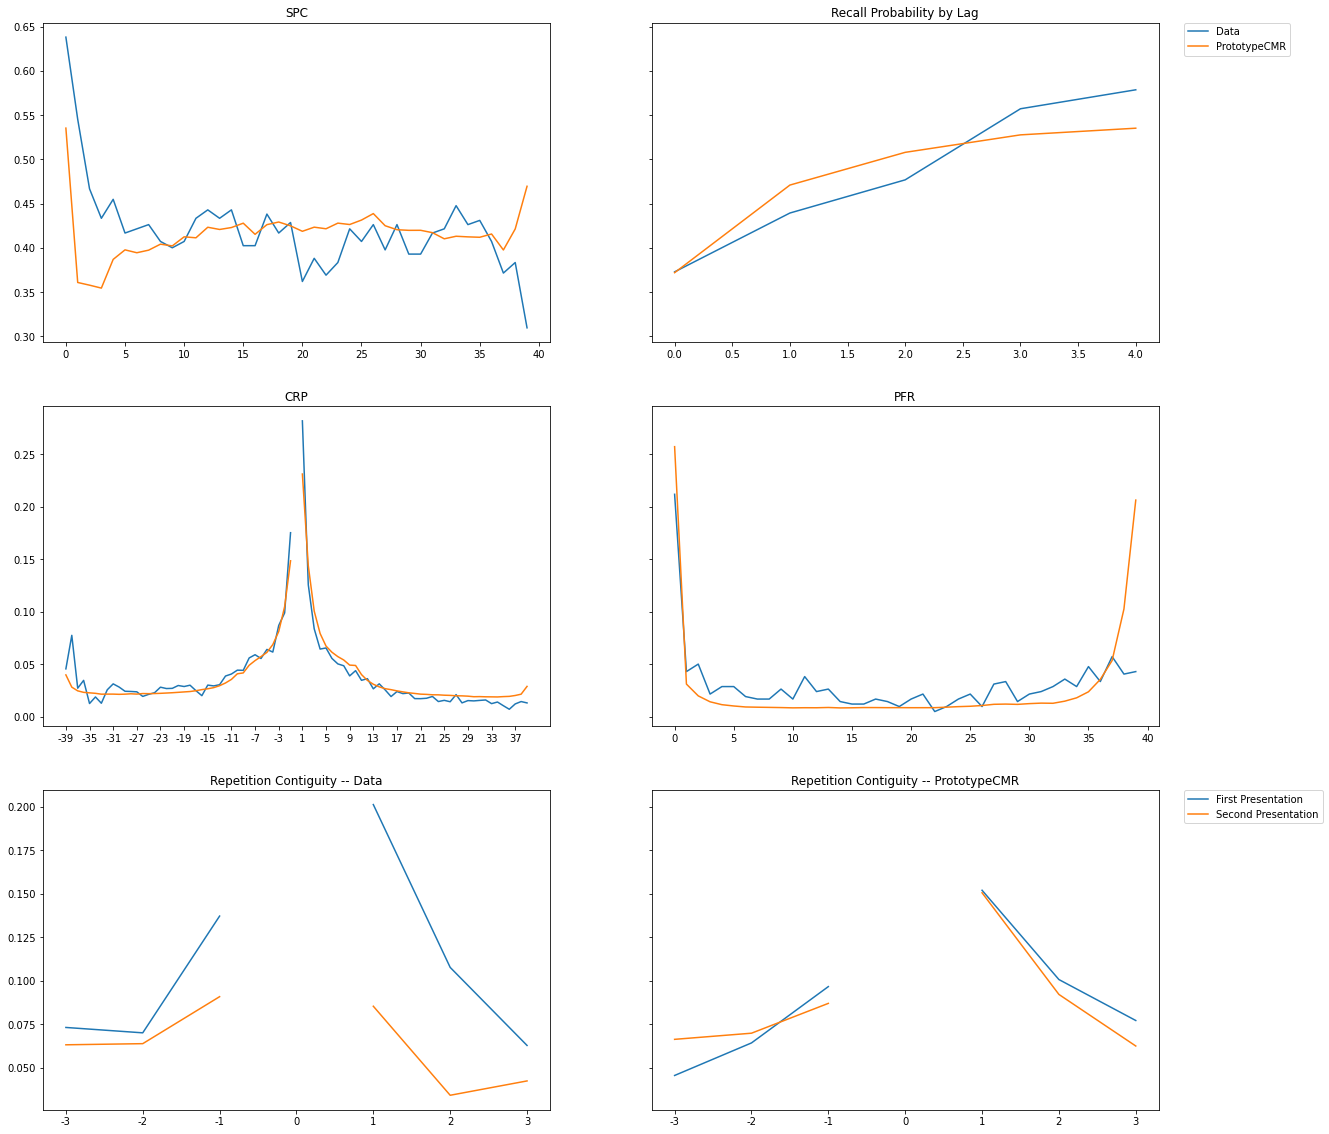

In [ ]:
model_name = 'PrototypeCMR'

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20, 20), sharey='row')

# spc
data_spc= flex_mixed_spc(trials[list_types==condition], presentations[list_types==condition])
cmr_spc = flex_mixed_spc(cmr_trials, cmr_presentations)
axes[0, 0].plot(np.arange(len(data_spc)), data_spc, label='Data')
axes[0, 0].plot(np.arange(len(cmr_spc)), cmr_spc, label=model_name)
axes[0, 0].set_title('SPC')

# pfr
data_pfr = flex_mixed_pfr(trials[list_types==condition], presentations[list_types==condition])
cmr_pfr = flex_mixed_pfr(cmr_trials, cmr_presentations)
axes[1, 1].plot(np.arange(len(data_pfr)), data_pfr, label='Data')
axes[1, 1].plot(np.arange(len(cmr_pfr)), cmr_pfr, label=model_name)
axes[1, 1].set_title('PFR')

# crp
lag_range = len(presentations[0])-1
data_crp= flex_mixed_crp(trials[list_types==condition], presentations[list_types==condition])
data_crp[lag_range] = np.nan
cmr_crp = flex_mixed_crp(cmr_trials, cmr_presentations)
cmr_crp[lag_range] = np.nan
axes[1, 0].plot(np.arange(len(data_crp)), data_crp, label='Data')
axes[1, 0].plot(np.arange(len(cmr_crp)), cmr_crp, label=model_name)
axes[1, 0].set_xticks(np.arange(0, len(data_crp), 4))
axes[1, 0].set_xticklabels(np.arange(0, len(data_crp), 4) - lag_range)
axes[1, 0].set_title('CRP')

# rpl
data_rpl = fast_rpl(
    trials[list_types==condition], presentations[list_types==condition], max_lag=8)
binned = np.zeros(5)
binned[0] = data_rpl[0]
binned[1] = data_rpl[1]
binned[2] = (data_rpl[2] + data_rpl[3])/2
binned[3] = (data_rpl[4] + data_rpl[5] + data_rpl[6])/3
binned[4] = (data_rpl[7] + data_rpl[8] + data_rpl[9])/3
data_rpl = binned.copy()

cmr_rpl = fast_rpl(
    cmr_trials, cmr_presentations, max_lag=8)
binned = np.zeros(5)
binned[0] = cmr_rpl[0]
binned[1] = cmr_rpl[1]
binned[2] = (cmr_rpl[2] + cmr_rpl[3])/2
binned[3] = (cmr_rpl[4] + cmr_rpl[5] + cmr_rpl[6])/3
binned[4] = (cmr_rpl[7] + cmr_rpl[8] + cmr_rpl[9])/3
cmr_rpl = binned.copy()

axes[0, 1].plot(np.arange(len(data_rpl)), data_rpl, label='Data')
axes[0, 1].plot(np.arange(len(cmr_rpl)), cmr_rpl, label=model_name)
axes[0, 1].set_title('Recall Probability by Lag')

# alt contiguity (data)
data_altcrp = alternative_contiguity(
    trials[list_types==condition], presentations[list_types==condition], 6, 2)
data_altcrp[:, lag_range] = np.nan
axes[2, 0].plot(np.arange(7), data_altcrp[0][lag_range-3:lag_range+4], label='First Presentation')
axes[2, 0].plot(np.arange(7), data_altcrp[1][lag_range-3:lag_range+4], label='Second Presentation')
axes[2, 0].set_xticks(np.arange(7))
axes[2, 0].set_xticklabels(np.arange(7) - 3)
axes[2, 0].set_title('Repetition Contiguity -- Data')

cmr_altcrp = alternative_contiguity(
    cmr_trials, cmr_presentations, 6, 2)
cmr_altcrp[:, lag_range] = np.nan
axes[2, 1].plot(np.arange(7), cmr_altcrp[0][lag_range-3:lag_range+4], label='First Presentation')
axes[2, 1].plot(np.arange(7), cmr_altcrp[1][lag_range-3:lag_range+4], label='Second Presentation')
axes[2, 1].set_xticks(np.arange(7))
axes[2, 1].set_xticklabels(np.arange(7) - 3)
axes[2, 1].set_title('Repetition Contiguity -- ' + model_name)

axes[0, 1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
axes[2, 1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);


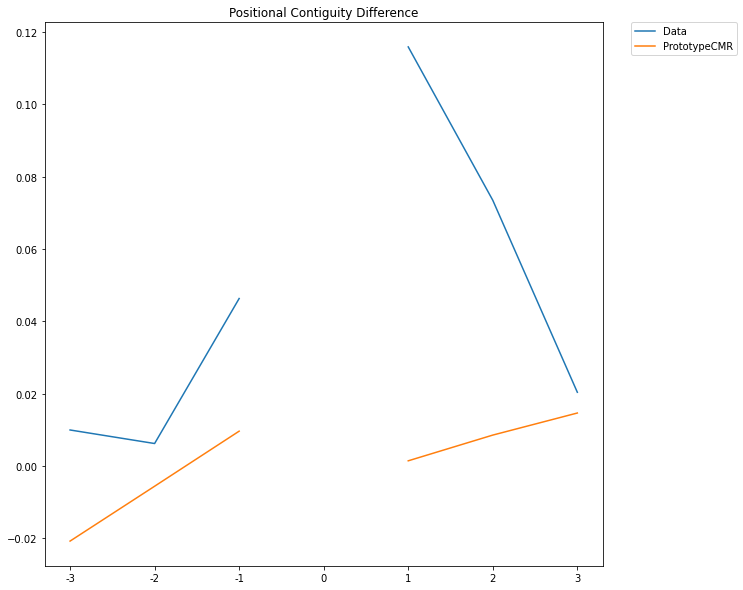

In [ ]:
model_name = 'PrototypeCMR'

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 10), sharey='row')

# alt contiguity (data)
data_altcrp = alternative_contiguity(
    trials[list_types==condition], presentations[list_types==condition], 6, 2)
data_altcrp[:, lag_range] = np.nan
cmr_altcrp = alternative_contiguity(
    cmr_trials, cmr_presentations, 6, 2)
cmr_altcrp[:, lag_range] = np.nan

axes.plot(np.arange(7), data_altcrp[0][lag_range-3:lag_range+4]-data_altcrp[1][lag_range-3:lag_range+4], label='Data')
axes.plot(np.arange(7), cmr_altcrp[0][lag_range-3:lag_range+4]-cmr_altcrp[1][lag_range-3:lag_range+4], label=model_name)
axes.set_xticks(np.arange(7))
axes.set_xticklabels(np.arange(7) - 3)
axes.set_title('Positional Contiguity Difference')

axes.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


### InstanceCMR

In [ ]:
lb = np.finfo(float).eps
ub = 1-np.finfo(float).eps

icmr_free_parameters = (
    'encoding_drift_rate',
    'start_drift_rate',
    'recall_drift_rate',
    'shared_support',
    'item_support',
    'learning_rate',
    'primacy_scale',
    'primacy_decay',
    'stop_probability_scale',
    'stop_probability_growth',
#    'choice_sensitivity',
    'context_sensitivity',
#    'feature_sensitivity'
    'delay_drift_rate',
)

icmr_bounds = [
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, 100),
    (lb, 100),
    (lb, ub),
    (lb, 10),
    (lb, 10),
#    (lb, 10),
#    (lb, 10)
    (lb, ub),
]

@njit(fastmath=True, nogil=True)
def init_icmr(item_count, presentation_count, parameters):
    return Instance_CMR(item_count, presentation_count, parameters)

condition = 4
selection = list_types == condition
cost_function = lohnas_objective_function(
    trials[selection], 
    presentations[selection],
    init_icmr,
    {'choice_sensitivity': 1, 'feature_sensitivity': 1}, 
    icmr_free_parameters)

icmr_result = differential_evolution(cost_function, icmr_bounds, disp=True)

differential_evolution step 1: f(x)= 46459.2
differential_evolution step 2: f(x)= 28269
differential_evolution step 3: f(x)= 26437.4
differential_evolution step 4: f(x)= 24436.2
differential_evolution step 5: f(x)= 24436.2
differential_evolution step 6: f(x)= 20687.5
differential_evolution step 7: f(x)= 20080.2
differential_evolution step 8: f(x)= 20065.4
differential_evolution step 9: f(x)= 19693.7
differential_evolution step 10: f(x)= 19693.7
differential_evolution step 11: f(x)= 19620.8
differential_evolution step 12: f(x)= 19620.8
differential_evolution step 13: f(x)= 19620.8
differential_evolution step 14: f(x)= 19620.8
differential_evolution step 15: f(x)= 19578.4
differential_evolution step 16: f(x)= 18942.2
differential_evolution step 17: f(x)= 18942.2
differential_evolution step 18: f(x)= 18942.2
differential_evolution step 19: f(x)= 18207
differential_evolution step 20: f(x)= 18207
differential_evolution step 21: f(x)= 18207
differential_evolution step 22: f(x)= 18207
differe

In [ ]:
icmr_result

     fun: 17221.459000970448
     jac: array([-34.70595385,  15.63421393,  22.91963017, 306.74091249,
       -33.19582901,   9.75414878, -11.35013015,   0.        ,
       -16.64921001,  71.7092917 , -10.55632317, -15.95180939])
 message: 'Optimization terminated successfully.'
    nfev: 12969
     nit: 60
 success: True
       x: array([8.32901225e-01, 2.08116235e-01, 9.60915690e-01, 3.05257500e-04,
       3.18582949e-02, 1.02883666e-01, 2.14975563e+00, 6.66001243e+01,
       2.05812661e-02, 1.09385203e-01, 1.35697460e+00, 9.42731805e-01])

In [ ]:
experiment_count = 1000

icmr_fitted_parameters = Dict.empty(
        key_type=types.unicode_type, value_type=types.float64)
for j in range(len(icmr_result.x)):
    icmr_fitted_parameters[icmr_free_parameters[j]] = icmr_result.x[j]
    
icmr_fitted_parameters['choice_sensitivity'] = 1
icmr_fitted_parameters['feature_sensitivity'] = 1

icmr_trials = simulate_array_from_presentations(
    init_icmr, icmr_fitted_parameters, presentations[list_types==condition], experiment_count)
icmr_presentations = np.matlib.repmat(presentations[list_types==condition], experiment_count, 1)

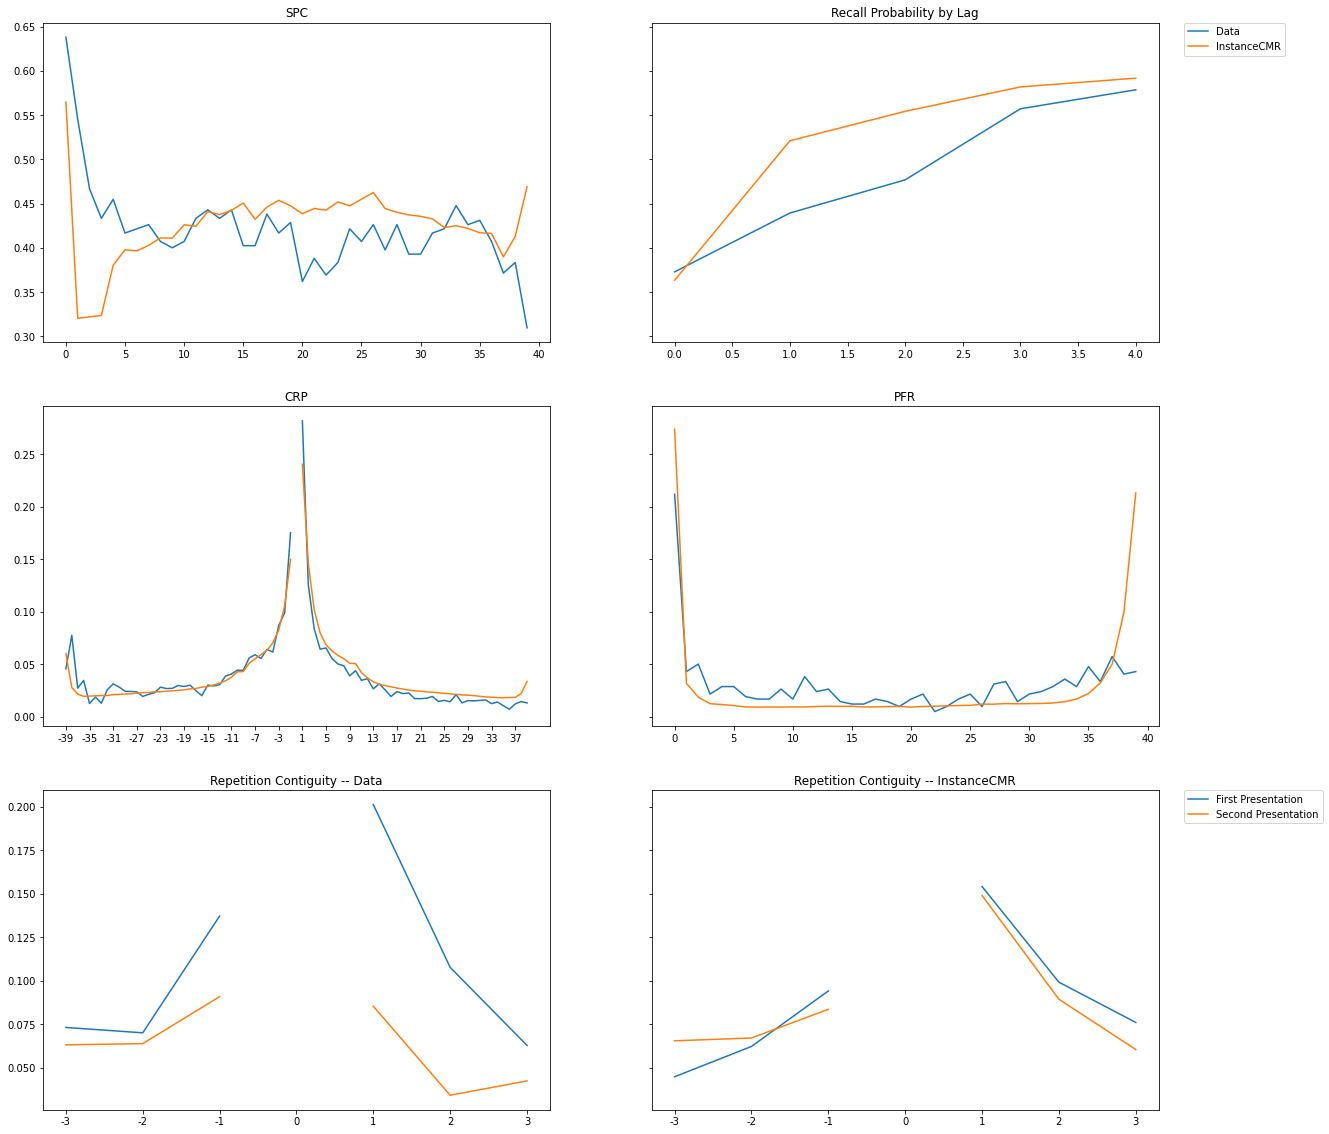

In [ ]:
model_name = 'InstanceCMR'

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20, 20), sharey='row')

# spc
data_spc= flex_mixed_spc(trials[list_types==condition], presentations[list_types==condition])
icmr_spc = flex_mixed_spc(icmr_trials, icmr_presentations)
axes[0, 0].plot(np.arange(len(data_spc)), data_spc, label='Data')
axes[0, 0].plot(np.arange(len(icmr_spc)), icmr_spc, label=model_name)
axes[0, 0].set_title('SPC')

# pfr
data_pfr = flex_mixed_pfr(trials[list_types==condition], presentations[list_types==condition])
icmr_pfr = flex_mixed_pfr(icmr_trials, icmr_presentations)
axes[1, 1].plot(np.arange(len(data_pfr)), data_pfr, label='Data')
axes[1, 1].plot(np.arange(len(icmr_pfr)), icmr_pfr, label=model_name)
axes[1, 1].set_title('PFR')

# crp
lag_range = len(presentations[0])-1
data_crp= flex_mixed_crp(trials[list_types==condition], presentations[list_types==condition])
data_crp[lag_range] = np.nan
icmr_crp = flex_mixed_crp(icmr_trials, icmr_presentations)
icmr_crp[lag_range] = np.nan
axes[1, 0].plot(np.arange(len(data_crp)), data_crp, label='Data')
axes[1, 0].plot(np.arange(len(icmr_crp)), icmr_crp, label=model_name)
axes[1, 0].set_xticks(np.arange(0, len(data_crp), 4))
axes[1, 0].set_xticklabels(np.arange(0, len(data_crp), 4) - lag_range)
axes[1, 0].set_title('CRP')

# rpl
data_rpl = fast_rpl(
    trials[list_types==condition], presentations[list_types==condition], max_lag=8)
binned = np.zeros(5)
binned[0] = data_rpl[0]
binned[1] = data_rpl[1]
binned[2] = (data_rpl[2] + data_rpl[3])/2
binned[3] = (data_rpl[4] + data_rpl[5] + data_rpl[6])/3
binned[4] = (data_rpl[7] + data_rpl[8] + data_rpl[9])/3
data_rpl = binned.copy()

icmr_rpl = fast_rpl(
    icmr_trials, icmr_presentations, max_lag=8)
binned = np.zeros(5)
binned[0] = icmr_rpl[0]
binned[1] = icmr_rpl[1]
binned[2] = (icmr_rpl[2] + icmr_rpl[3])/2
binned[3] = (icmr_rpl[4] + icmr_rpl[5] + icmr_rpl[6])/3
binned[4] = (icmr_rpl[7] + icmr_rpl[8] + icmr_rpl[9])/3
icmr_rpl = binned.copy()

axes[0, 1].plot(np.arange(len(data_rpl)), data_rpl, label='Data')
axes[0, 1].plot(np.arange(len(icmr_rpl)), icmr_rpl, label=model_name)
axes[0, 1].set_title('Recall Probability by Lag')

# alt contiguity (data)
data_altcrp = alternative_contiguity(
    trials[list_types==condition], presentations[list_types==condition], 6, 2)
data_altcrp[:, lag_range] = np.nan
axes[2, 0].plot(np.arange(7), data_altcrp[0][lag_range-3:lag_range+4], label='First Presentation')
axes[2, 0].plot(np.arange(7), data_altcrp[1][lag_range-3:lag_range+4], label='Second Presentation')
axes[2, 0].set_xticks(np.arange(7))
axes[2, 0].set_xticklabels(np.arange(7) - 3)
axes[2, 0].set_title('Repetition Contiguity -- Data')

icmr_altcrp = alternative_contiguity(
    icmr_trials, icmr_presentations, 6, 2)
icmr_altcrp[:, lag_range] = np.nan
axes[2, 1].plot(np.arange(7), icmr_altcrp[0][lag_range-3:lag_range+4], label='First Presentation')
axes[2, 1].plot(np.arange(7), icmr_altcrp[1][lag_range-3:lag_range+4], label='Second Presentation')
axes[2, 1].set_xticks(np.arange(7))
axes[2, 1].set_xticklabels(np.arange(7) - 3)
axes[2, 1].set_title('Repetition Contiguity -- ' + model_name)

axes[0, 1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
axes[2, 1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);


### Trace_Reinstatement_CMR

In [ ]:
# remember to run nbdev_build_lib first! 

import compmemlearn
import importlib
importlib.reload(compmemlearn.models)
from compmemlearn.models import Trace_Reinstatement_CMR

In [ ]:
trcmr_free_parameters = (
    'encoding_drift_rate',
    'start_drift_rate',
    'recall_drift_rate',
    'shared_support',
    'item_support',
    'learning_rate',
    'primacy_scale',
    'primacy_decay',
    'stop_probability_scale',
    'stop_probability_growth',
#    'choice_sensitivity',
    'context_sensitivity',
#    'feature_sensitivity'
    'delay_drift_rate',
    'context_reinstatement'
)

trcmr_bounds = [
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, ub),
    (lb, 100),
    (lb, 100),
    (lb, ub),
    (lb, 10),
    (lb, 10),
#    (lb, 10),
#    (lb, 10)
    (lb, ub),
    (1, 10)
]

@njit(fastmath=True, nogil=True)
def init_trcmr(item_count, presentation_count, parameters):
    return Trace_Reinstatement_CMR(item_count, presentation_count, parameters)

condition = 4
selection = list_types == condition
cost_function = lohnas_objective_function(
    trials[selection], 
    presentations[selection],
    init_trcmr,
    {'choice_sensitivity': 1, 'feature_sensitivity': 1}, 
    trcmr_free_parameters)

# will throw error if i haven't already fitted
print(init_trcmr(20, 20, trcmr_fitted_parameters).items[0]) # to maybe avoid weird fitting failure -- we'll see if it works



[0.         0.02499219 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.99968765
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]


In [ ]:
trcmr_result = differential_evolution(cost_function, trcmr_bounds, disp=True)
trcmr_result

differential_evolution step 1: f(x)= 38770.8
differential_evolution step 2: f(x)= 31970
differential_evolution step 3: f(x)= 28471.3
differential_evolution step 4: f(x)= 20224.9
differential_evolution step 5: f(x)= 20053.9
differential_evolution step 6: f(x)= 19901.2
differential_evolution step 7: f(x)= 19746.1
differential_evolution step 8: f(x)= 19671.3
differential_evolution step 9: f(x)= 19671.3
differential_evolution step 10: f(x)= 19671.3
differential_evolution step 11: f(x)= 19671.3
differential_evolution step 12: f(x)= 19671.3
differential_evolution step 13: f(x)= 19654.2
differential_evolution step 14: f(x)= 19625.7
differential_evolution step 15: f(x)= 19574.9
differential_evolution step 16: f(x)= 19574.9
differential_evolution step 17: f(x)= 19574.9
differential_evolution step 18: f(x)= 19574.9
differential_evolution step 19: f(x)= 19574.9
differential_evolution step 20: f(x)= 19373.8
differential_evolution step 21: f(x)= 19373.8
differential_evolution step 22: f(x)= 19373.8

     fun: 17059.651290065947
     jac: array([-3.95208188e+01, -4.22016456e+01, -1.21831908e+02,  5.78427716e+01,
       -1.35005394e+00,  1.87246768e+00, -1.51703717e-01,  0.00000000e+00,
       -8.20444256e+01,  1.97843110e+02,  1.71508874e+01, -6.52773448e+02,
       -6.14309105e+00])
 message: 'Optimization terminated successfully.'
    nfev: 12317
     nit: 30
 success: True
       x: array([8.32287621e-01, 6.19383237e-03, 9.14802390e-01, 6.03601368e-03,
       3.49635680e-01, 7.39360206e-01, 2.72092798e+00, 4.64522241e+01,
       1.91378214e-02, 1.14005522e-01, 2.29533351e+00, 9.99988823e-01,
       5.73518735e+00])

#### With Maxed Out Context Reinstatement

[0.         0.02499219 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.99968765
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]


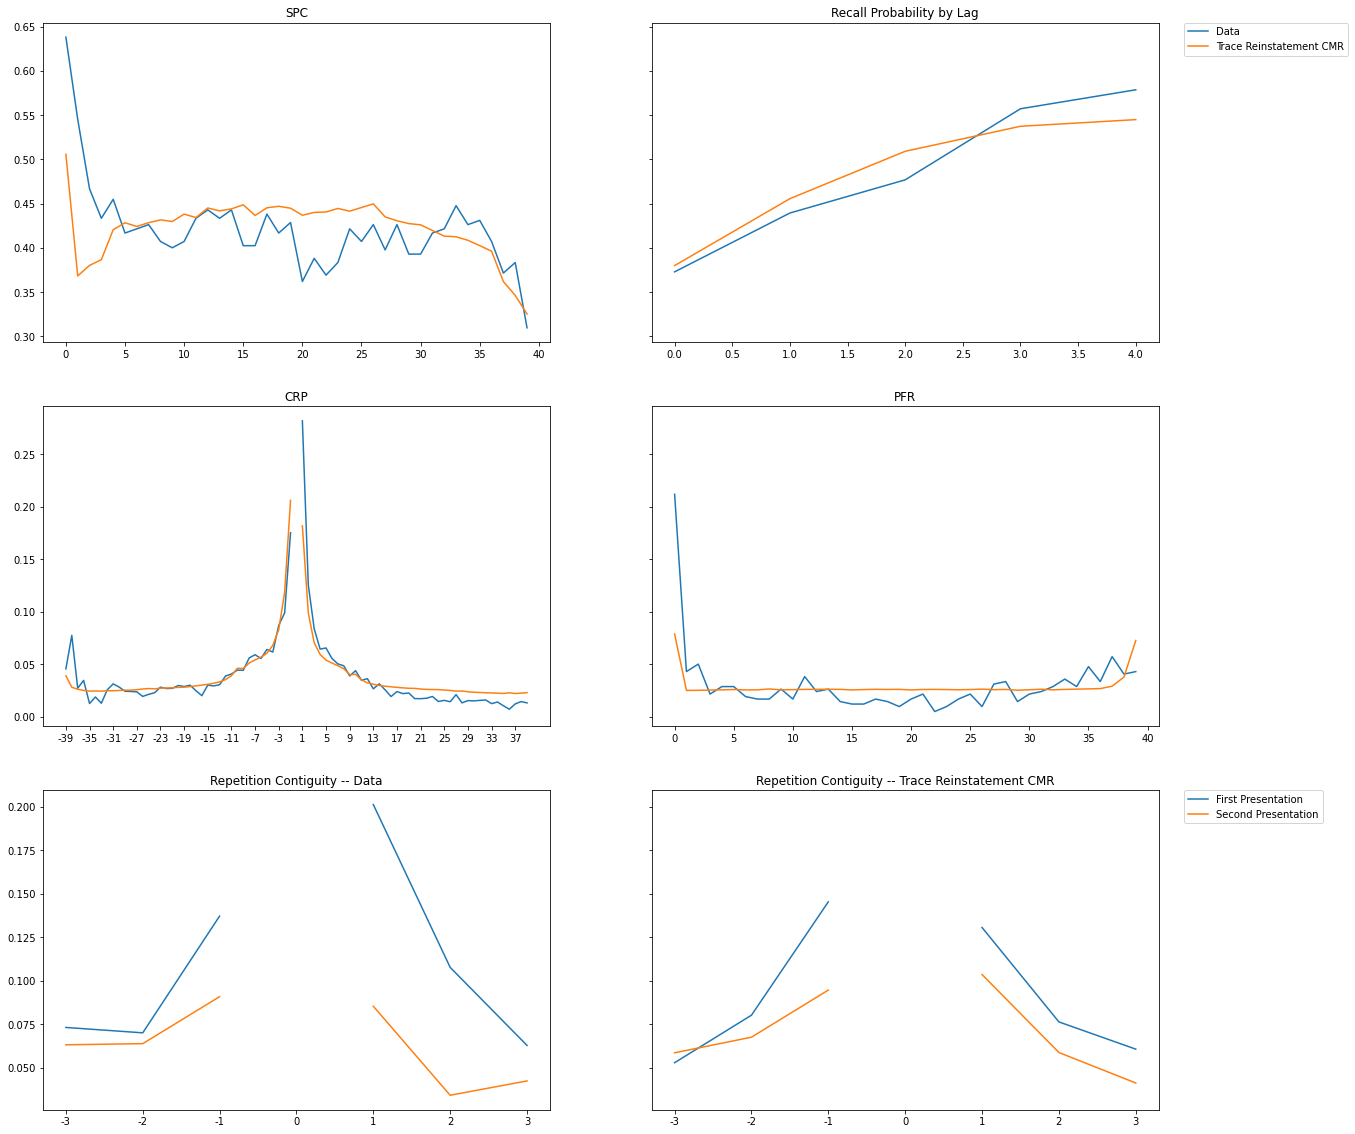

In [ ]:
experiment_count = 1000

trcmr_fitted_parameters = Dict.empty(
        key_type=types.unicode_type, value_type=types.float64)
for j in range(len(trcmr_result.x)):
    trcmr_fitted_parameters[trcmr_free_parameters[j]] = trcmr_result.x[j]
    
trcmr_fitted_parameters['choice_sensitivity'] = 1
trcmr_fitted_parameters['feature_sensitivity'] = 1
trcmr_fitted_parameters['context_reinstatement'] = 40 # hack to drive alternative contiguity effect

# will throw error if i haven't already fitted
print(init_trcmr(20, 20, trcmr_fitted_parameters).items[0]) # to maybe avoid weird fitting failure -- we'll see if it works

trcmr_trials = simulate_array_from_presentations(
    init_trcmr, trcmr_fitted_parameters, presentations[list_types==condition], experiment_count)
trcmr_presentations = np.matlib.repmat(presentations[list_types==condition], experiment_count, 1)

model_name = 'Trace Reinstatement CMR'

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20, 20), sharey='row')

# spc
data_spc= flex_mixed_spc(trials[list_types==condition], presentations[list_types==condition])
trcmr_spc = flex_mixed_spc(trcmr_trials, trcmr_presentations)
axes[0, 0].plot(np.arange(len(data_spc)), data_spc, label='Data')
axes[0, 0].plot(np.arange(len(trcmr_spc)), trcmr_spc, label=model_name)
axes[0, 0].set_title('SPC')

# pfr
data_pfr = flex_mixed_pfr(trials[list_types==condition], presentations[list_types==condition])
trcmr_pfr = flex_mixed_pfr(trcmr_trials, trcmr_presentations)
axes[1, 1].plot(np.arange(len(data_pfr)), data_pfr, label='Data')
axes[1, 1].plot(np.arange(len(trcmr_pfr)), trcmr_pfr, label=model_name)
axes[1, 1].set_title('PFR')

# crp
lag_range = len(presentations[0])-1
data_crp= flex_mixed_crp(trials[list_types==condition], presentations[list_types==condition])
data_crp[lag_range] = np.nan
trcmr_crp = flex_mixed_crp(trcmr_trials, trcmr_presentations)
trcmr_crp[lag_range] = np.nan
axes[1, 0].plot(np.arange(len(data_crp)), data_crp, label='Data')
axes[1, 0].plot(np.arange(len(trcmr_crp)), trcmr_crp, label=model_name)
axes[1, 0].set_xticks(np.arange(0, len(data_crp), 4))
axes[1, 0].set_xticklabels(np.arange(0, len(data_crp), 4) - lag_range)
axes[1, 0].set_title('CRP')

# rpl
data_rpl = fast_rpl(
    trials[list_types==condition], presentations[list_types==condition], max_lag=8)
binned = np.zeros(5)
binned[0] = data_rpl[0]
binned[1] = data_rpl[1]
binned[2] = (data_rpl[2] + data_rpl[3])/2
binned[3] = (data_rpl[4] + data_rpl[5] + data_rpl[6])/3
binned[4] = (data_rpl[7] + data_rpl[8] + data_rpl[9])/3
data_rpl = binned.copy()

trcmr_rpl = fast_rpl(
    trcmr_trials, trcmr_presentations, max_lag=8)
binned = np.zeros(5)
binned[0] = trcmr_rpl[0]
binned[1] = trcmr_rpl[1]
binned[2] = (trcmr_rpl[2] + trcmr_rpl[3])/2
binned[3] = (trcmr_rpl[4] + trcmr_rpl[5] + trcmr_rpl[6])/3
binned[4] = (trcmr_rpl[7] + trcmr_rpl[8] + trcmr_rpl[9])/3
trcmr_rpl = binned.copy()

axes[0, 1].plot(np.arange(len(data_rpl)), data_rpl, label='Data')
axes[0, 1].plot(np.arange(len(trcmr_rpl)), trcmr_rpl, label=model_name)
axes[0, 1].set_title('Recall Probability by Lag')

# alt contiguity (data)
data_altcrp = alternative_contiguity(
    trials[list_types==condition], presentations[list_types==condition], 6, 2)
data_altcrp[:, lag_range] = np.nan
axes[2, 0].plot(np.arange(7), data_altcrp[0][lag_range-3:lag_range+4], label='First Presentation')
axes[2, 0].plot(np.arange(7), data_altcrp[1][lag_range-3:lag_range+4], label='Second Presentation')
axes[2, 0].set_xticks(np.arange(7))
axes[2, 0].set_xticklabels(np.arange(7) - 3)
axes[2, 0].set_title('Repetition Contiguity -- Data')

trcmr_altcrp = alternative_contiguity(
    trcmr_trials, trcmr_presentations, 6, 2)
trcmr_altcrp[:, lag_range] = np.nan
axes[2, 1].plot(np.arange(7), trcmr_altcrp[0][lag_range-3:lag_range+4], label='First Presentation')
axes[2, 1].plot(np.arange(7), trcmr_altcrp[1][lag_range-3:lag_range+4], label='Second Presentation')
axes[2, 1].set_xticks(np.arange(7))
axes[2, 1].set_xticklabels(np.arange(7) - 3)
axes[2, 1].set_title('Repetition Contiguity -- ' + model_name)

axes[0, 1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
axes[2, 1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);


#### With Parametrized Amount

In [ ]:
experiment_count = 1000

trcmr_fitted_parameters = Dict.empty(
        key_type=types.unicode_type, value_type=types.float64)
for j in range(len(trcmr_result.x)):
    trcmr_fitted_parameters[trcmr_free_parameters[j]] = trcmr_result.x[j]
    
trcmr_fitted_parameters['choice_sensitivity'] = 1
trcmr_fitted_parameters['feature_sensitivity'] = 1

# will throw error if i haven't already fitted
print(init_trcmr(20, 20, trcmr_fitted_parameters).items[0]) # to maybe avoid weird fitting failure -- we'll see if it works

trcmr_trials = simulate_array_from_presentations(
    init_trcmr, trcmr_fitted_parameters, presentations[list_types==condition], experiment_count)
trcmr_presentations = np.matlib.repmat(presentations[list_types==condition], experiment_count, 1)

[0.         0.17177067 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.98513696
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]


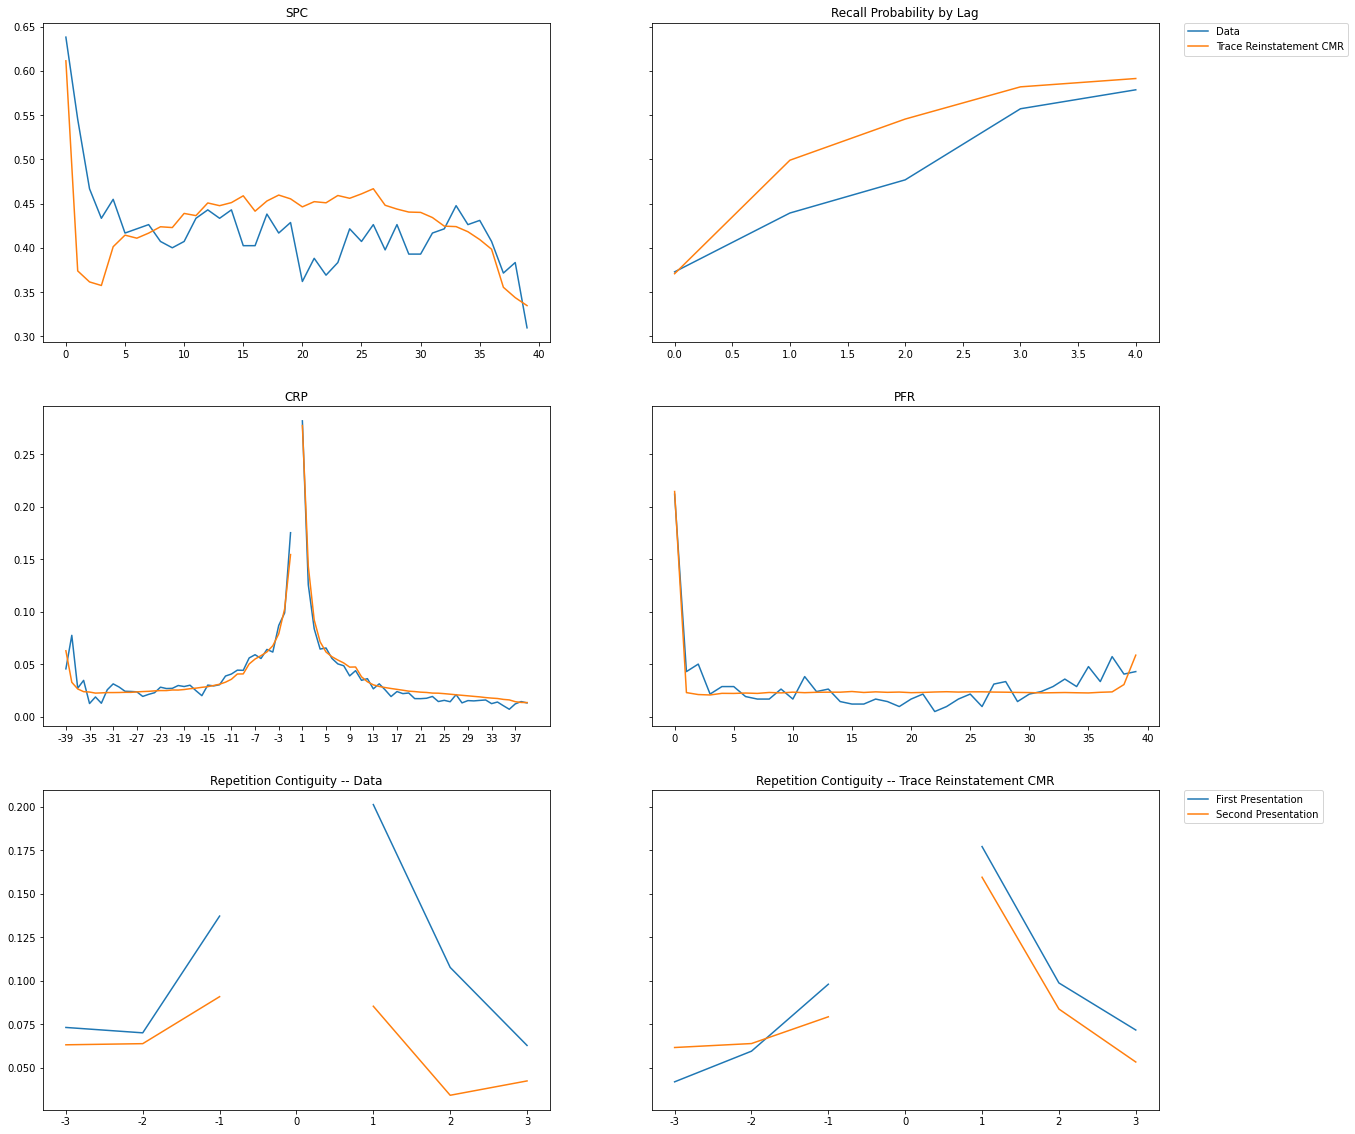

In [ ]:
model_name = 'Trace Reinstatement CMR'

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20, 20), sharey='row')

# spc
data_spc= flex_mixed_spc(trials[list_types==condition], presentations[list_types==condition])
trcmr_spc = flex_mixed_spc(trcmr_trials, trcmr_presentations)
axes[0, 0].plot(np.arange(len(data_spc)), data_spc, label='Data')
axes[0, 0].plot(np.arange(len(trcmr_spc)), trcmr_spc, label=model_name)
axes[0, 0].set_title('SPC')

# pfr
data_pfr = flex_mixed_pfr(trials[list_types==condition], presentations[list_types==condition])
trcmr_pfr = flex_mixed_pfr(trcmr_trials, trcmr_presentations)
axes[1, 1].plot(np.arange(len(data_pfr)), data_pfr, label='Data')
axes[1, 1].plot(np.arange(len(trcmr_pfr)), trcmr_pfr, label=model_name)
axes[1, 1].set_title('PFR')

# crp
lag_range = len(presentations[0])-1
data_crp= flex_mixed_crp(trials[list_types==condition], presentations[list_types==condition])
data_crp[lag_range] = np.nan
trcmr_crp = flex_mixed_crp(trcmr_trials, trcmr_presentations)
trcmr_crp[lag_range] = np.nan
axes[1, 0].plot(np.arange(len(data_crp)), data_crp, label='Data')
axes[1, 0].plot(np.arange(len(trcmr_crp)), trcmr_crp, label=model_name)
axes[1, 0].set_xticks(np.arange(0, len(data_crp), 4))
axes[1, 0].set_xticklabels(np.arange(0, len(data_crp), 4) - lag_range)
axes[1, 0].set_title('CRP')

# rpl
data_rpl = fast_rpl(
    trials[list_types==condition], presentations[list_types==condition], max_lag=8)
binned = np.zeros(5)
binned[0] = data_rpl[0]
binned[1] = data_rpl[1]
binned[2] = (data_rpl[2] + data_rpl[3])/2
binned[3] = (data_rpl[4] + data_rpl[5] + data_rpl[6])/3
binned[4] = (data_rpl[7] + data_rpl[8] + data_rpl[9])/3
data_rpl = binned.copy()

trcmr_rpl = fast_rpl(
    trcmr_trials, trcmr_presentations, max_lag=8)
binned = np.zeros(5)
binned[0] = trcmr_rpl[0]
binned[1] = trcmr_rpl[1]
binned[2] = (trcmr_rpl[2] + trcmr_rpl[3])/2
binned[3] = (trcmr_rpl[4] + trcmr_rpl[5] + trcmr_rpl[6])/3
binned[4] = (trcmr_rpl[7] + trcmr_rpl[8] + trcmr_rpl[9])/3
trcmr_rpl = binned.copy()

axes[0, 1].plot(np.arange(len(data_rpl)), data_rpl, label='Data')
axes[0, 1].plot(np.arange(len(trcmr_rpl)), trcmr_rpl, label=model_name)
axes[0, 1].set_title('Recall Probability by Lag')

# alt contiguity (data)
data_altcrp = alternative_contiguity(
    trials[list_types==condition], presentations[list_types==condition], 6, 2)
data_altcrp[:, lag_range] = np.nan
axes[2, 0].plot(np.arange(7), data_altcrp[0][lag_range-3:lag_range+4], label='First Presentation')
axes[2, 0].plot(np.arange(7), data_altcrp[1][lag_range-3:lag_range+4], label='Second Presentation')
axes[2, 0].set_xticks(np.arange(7))
axes[2, 0].set_xticklabels(np.arange(7) - 3)
axes[2, 0].set_title('Repetition Contiguity -- Data')

trcmr_altcrp = alternative_contiguity(
    trcmr_trials, trcmr_presentations, 6, 2)
trcmr_altcrp[:, lag_range] = np.nan
axes[2, 1].plot(np.arange(7), trcmr_altcrp[0][lag_range-3:lag_range+4], label='First Presentation')
axes[2, 1].plot(np.arange(7), trcmr_altcrp[1][lag_range-3:lag_range+4], label='Second Presentation')
axes[2, 1].set_xticks(np.arange(7))
axes[2, 1].set_xticklabels(np.arange(7) - 3)
axes[2, 1].set_title('Repetition Contiguity -- ' + model_name)

axes[0, 1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
axes[2, 1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);


## Lag-Connectivity
To begin our analysis of model representations underlying this effect, we'll develop an extension of the lag-connectivity analysis that tracks whether our memory representations similarly disfavor the repetition contiguity effect.

We'll simulate each study sequence presented in the study. After each simulation, we'll identify items that were presented repeatedly with some minimum spacing between repetitions (usually 6). Then we'll track for lags in range [-3, 3] from each study position the mean connection weight between the focused item and item at the corresponding lag.

### Functions

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def matrix_heatmap(matrix, title='', figsize=(15, 15), savefig=False, axis=None):
    """

    **Arguments**:  
    - matrix: an array of model states, ideally with columns representing unique feature indices and rows
        representing unique update indices  
    - title: a title for the generated plot, ideally conveying what array values represent at each entry  
    - savefig: boolean deciding whether generated figure is saved (True if Yes)
    """
    plt.figure(figsize=figsize)
    sns.heatmap(matrix, annot=True, linewidths=.5, ax=axis)
    plt.title(title)
    plt.xlabel('Feature Index')
    plt.ylabel('Update Index')
    if savefig:
        plt.savefig('figures/{}.jpeg'.format(title).replace(' ', '_').lower(), bbox_inches='tight')
    plt.show()

def icmr_memory_heatmap(model, just_experimental=False, just_context=False):
    memory_shape = np.shape(model.memory)
    fig_size = list(reversed(memory_shape))
    plotted_memory = model.memory.copy()
    title = "Memory Traces"

    if just_context:
        fig_size[0] /= 2
        plotted_memory = plotted_memory[:, int(memory_shape[1]/2):]
        title = "Contextual " + title

    if just_experimental:
        fig_size[1] -= model.item_count
        plotted_memory = plotted_memory[model.item_count:]
        title = "Experimental " + title


    matrix_heatmap(plotted_memory, title, figsize=fig_size)
    
def mixed_connectivity_by_lag(item_connections, presentation):
    item_count = np.max(presentation)+1
    lag_range = len(presentation) - 1
    total_connectivity = np.zeros(lag_range * 2 + 1)
    total_possible_lags = np.zeros(lag_range * 2 + 1)
    item_positions = np.arange(len(presentation), dtype=int)

    for item in range(item_count):

        # only consider items that are repeated
        current_positions = np.nonzero(presentation == item)[0]

        # we consider each study position of repeated items separately
        for position_index in range(len(current_positions)):

            # lag of each item from current item is item_positions - current_position, 
            # and will always be in range [-lag_range, lag_range] so we keep position by adding lag_range
            item_lags = item_positions - current_positions[position_index] + lag_range
            total_connectivity[item_lags[presentation != item]] += item_connections[item, presentation[presentation != item]]
            total_possible_lags[item_lags[presentation != item]] += 1

    # divide by possible lags to get average connectivity
    total_possible_lags[total_connectivity == 0] += 1
    connectivity = total_connectivity / total_possible_lags
    return connectivity

def alternative_connectivity_by_lag(item_connections, presentation, minimum_lag=6, max_repeats=2):

    item_count = np.max(presentation)+1
    lag_range = len(presentation) - 1
    total_connectivity = np.zeros((max_repeats, lag_range * 2 + 1))
    total_possible_lags = np.zeros((max_repeats, lag_range * 2 + 1))
    item_positions = np.arange(len(presentation), dtype=int)

    for item in range(item_count):

        # only consider items that are repeated
        current_positions = np.nonzero(presentation == item)[0]
        if len(current_positions) < max_repeats:
            continue

        # only consider items with repeats of lag >= minimum_lag
        assert(current_positions[1] > current_positions[0])
        if current_positions[1] - current_positions[0] < minimum_lag:
            continue

        # we consider each study position of repeated items separately
        for position_index in range(max_repeats):

            # lag of each item from current item is item_positions - current_position, 
            # and will always be in range [-lag_range, lag_range] so we keep position by adding lag_range
            item_lags = item_positions - current_positions[position_index] + lag_range
            total_connectivity[position_index, item_lags] += item_connections[item, presentation]
            total_possible_lags[position_index, item_lags] += 1

    # divide by possible lags to get average connectivity
    total_possible_lags[total_connectivity == 0] += 1
    connectivity = total_connectivity / total_possible_lags
    return connectivity

### InstanceCMR

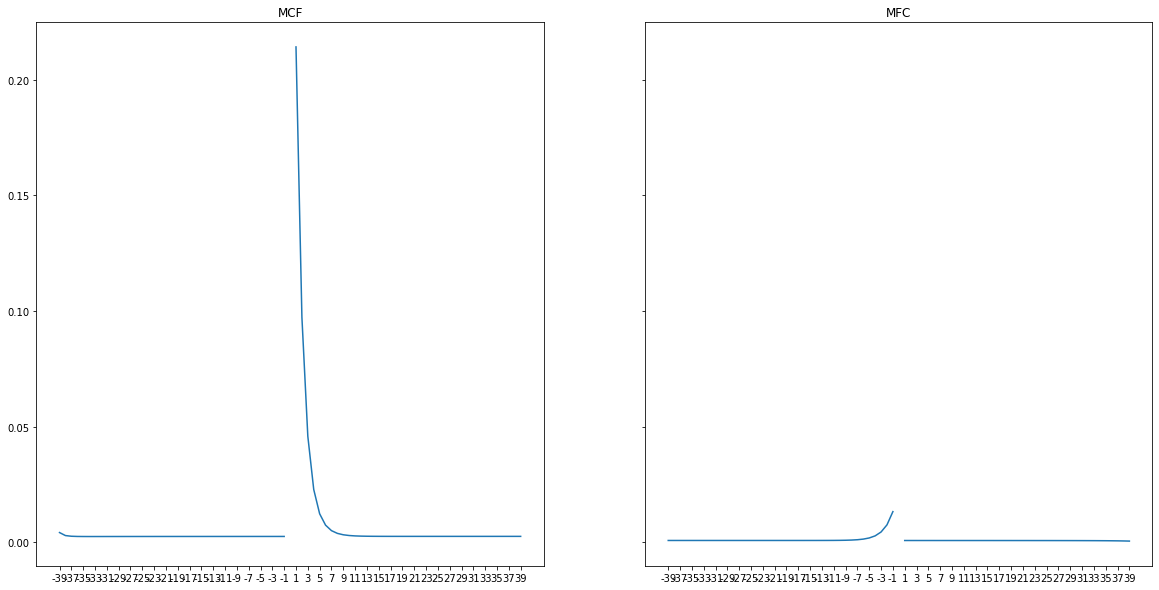

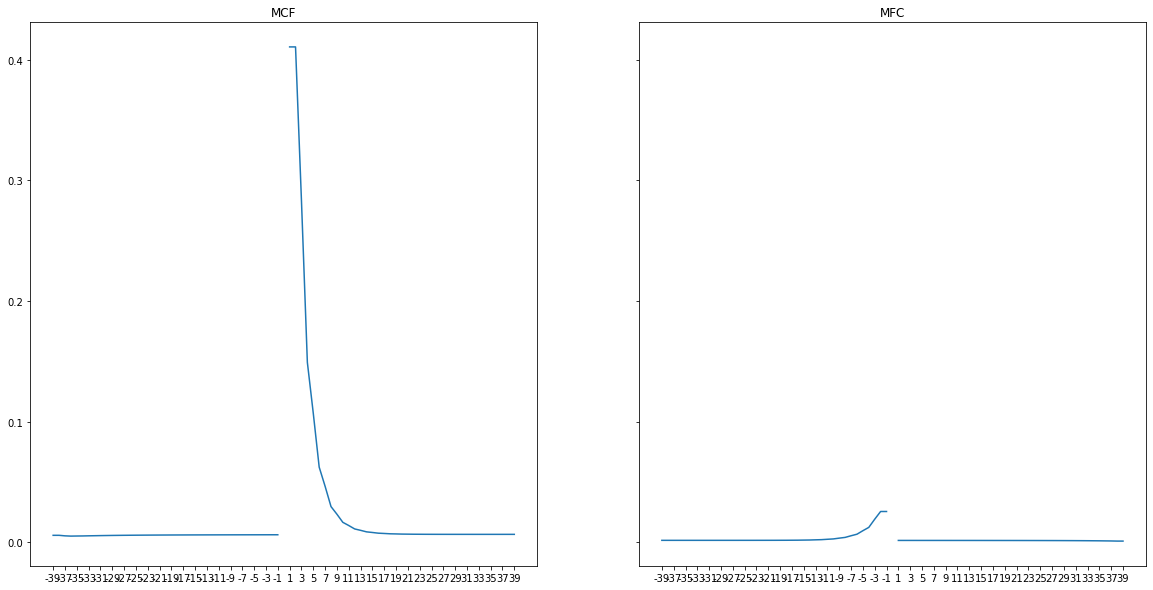

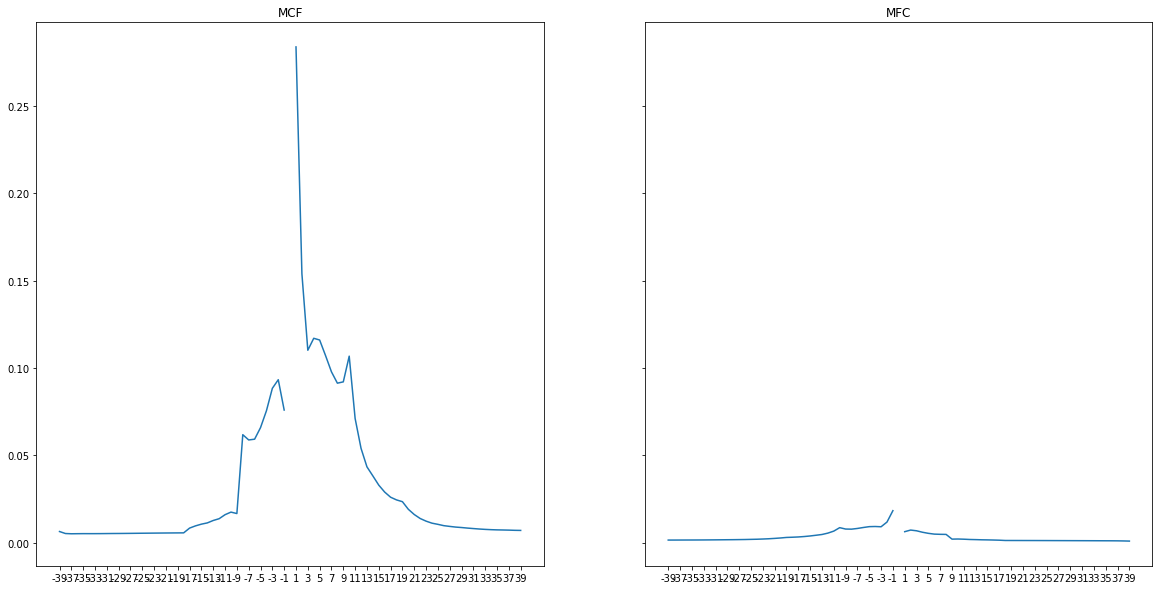

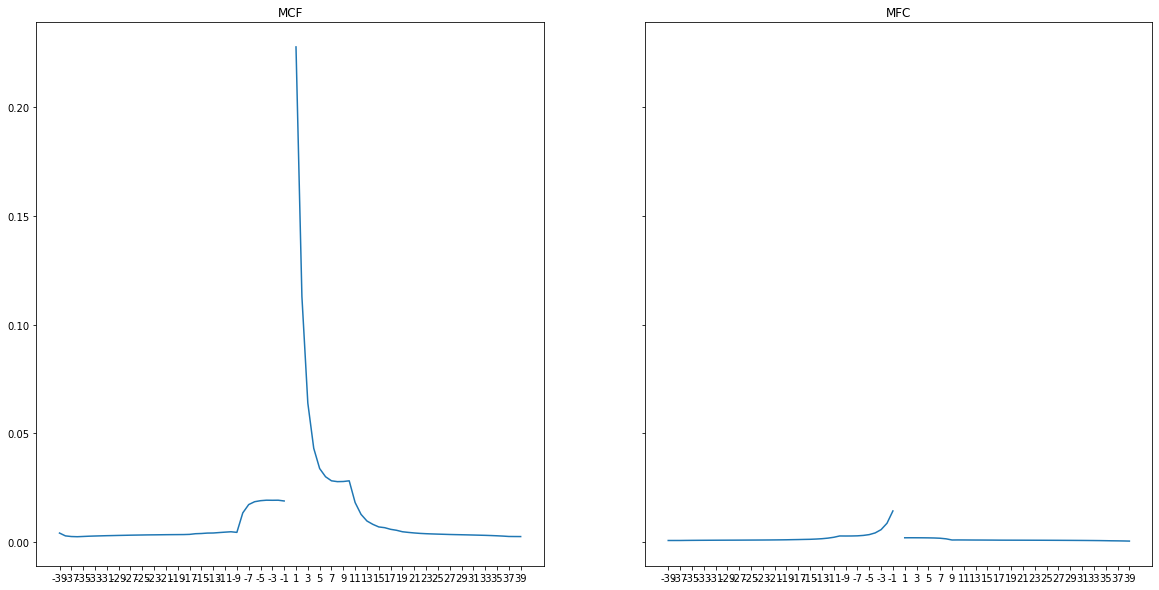

In [ ]:
# configure parameters
model_class = Instance_CMR
model_parameters = icmr_fitted_parameters

# track results
global_lag_range = 39

for list_type in [1, 2, 3, 4]:
    mfc_alternative_connectivities = np.zeros((2, global_lag_range * 2 + 1))
    mcf_alternative_connectivities = np.zeros((2, global_lag_range * 2 + 1))

    # loop through presentations
    for trial_index, presentation in enumerate(presentations[list_types==list_type]):

        # simulate list study
        item_count = np.max(presentation)+1
        model = model_class(item_count, len(presentation), model_parameters)
        model.experience(model.items[presentation])
        lag_range = item_count+1

        # extract item connections
        if model_class.__name__ == 'Classic_CMR':
            mfc_connections = model.mfc[:, 1:-1]
            mcf_connections = model.mcf[1:-1, :]
        else:
            latent_mfc, latent_mcf = latent_mfc_mcf(model)
            mfc_connections = latent_mfc[:, 1:-1]
            mcf_connections = latent_mcf[:, 1:-1]

        # track alternative connectivity
        mfc_alternative_connectivities[0] += mixed_connectivity_by_lag(mfc_connections, presentation)
        mcf_alternative_connectivities[0] += mixed_connectivity_by_lag(mcf_connections, presentation)
        #mfc_alternative_connectivities += alternative_connectivity_by_lag(mfc_connections, presentation)[:, lag_range-3:lag_range+4]
        #mcf_alternative_connectivities += alternative_connectivity_by_lag(mcf_connections, presentation)[:, lag_range-3:lag_range+4]

    # reduce sum to mean
    mfc_alternative_connectivity = mfc_alternative_connectivities / (trial_index+1)
    mcf_alternative_connectivity = mcf_alternative_connectivities / (trial_index+1)
    mfc_alternative_connectivity[:, global_lag_range] = np.nan
    mcf_alternative_connectivity[:, global_lag_range] = np.nan

    # plot results
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 20/2), sharey=True)
    axes[0].plot(np.arange(len(mcf_alternative_connectivity[0])), mcf_alternative_connectivity[0], label='First Presentation')
    #axes[0].plot(np.arange(len(mcf_alternative_connectivity[1])), mcf_alternative_connectivity[1], label='Second Presentation')
    axes[0].set_xticks(np.arange(0, global_lag_range * 2 + 1, 2))
    axes[0].set_xticklabels(np.arange(0, global_lag_range * 2 + 1, 2) - global_lag_range)
    axes[0].set_title('MCF')

    # same for MFC
    axes[1].plot(np.arange(len(mfc_alternative_connectivity[0])), mfc_alternative_connectivity[0], label='First Presentation')
    #axes[1].plot(np.arange(len(mfc_alternative_connectivity[1])), mfc_alternative_connectivity[1], label='Second Presentation')
    axes[1].set_xticks(np.arange(0, global_lag_range * 2 + 1, 2))
    axes[1].set_xticklabels(np.arange(0, global_lag_range * 2 + 1, 2) - global_lag_range)
    axes[1].set_title('MFC')


### Classic CMR

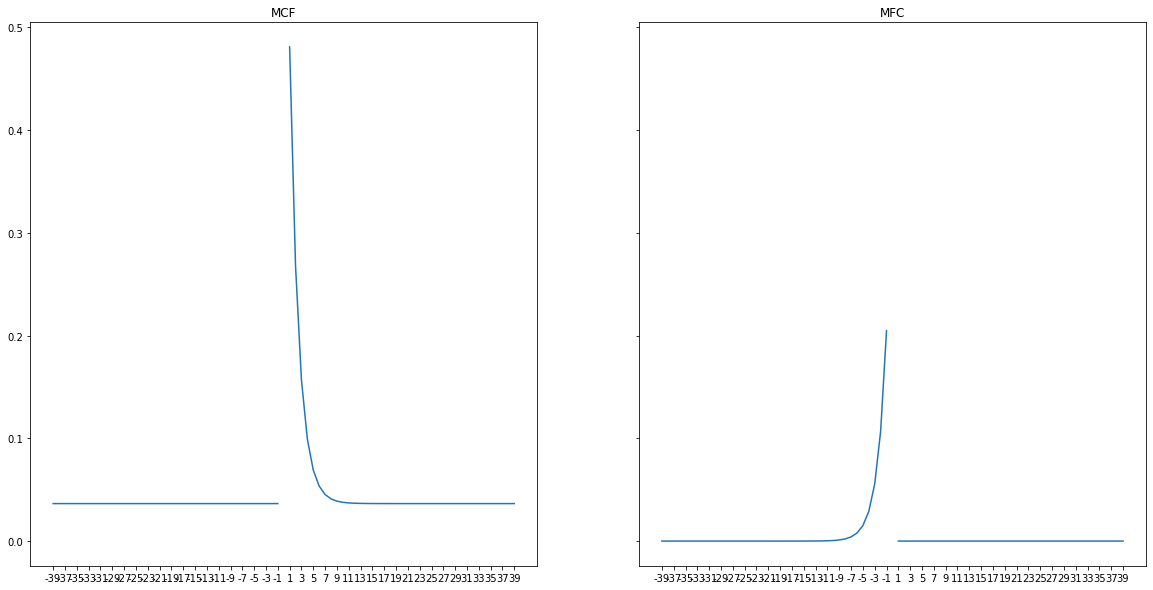

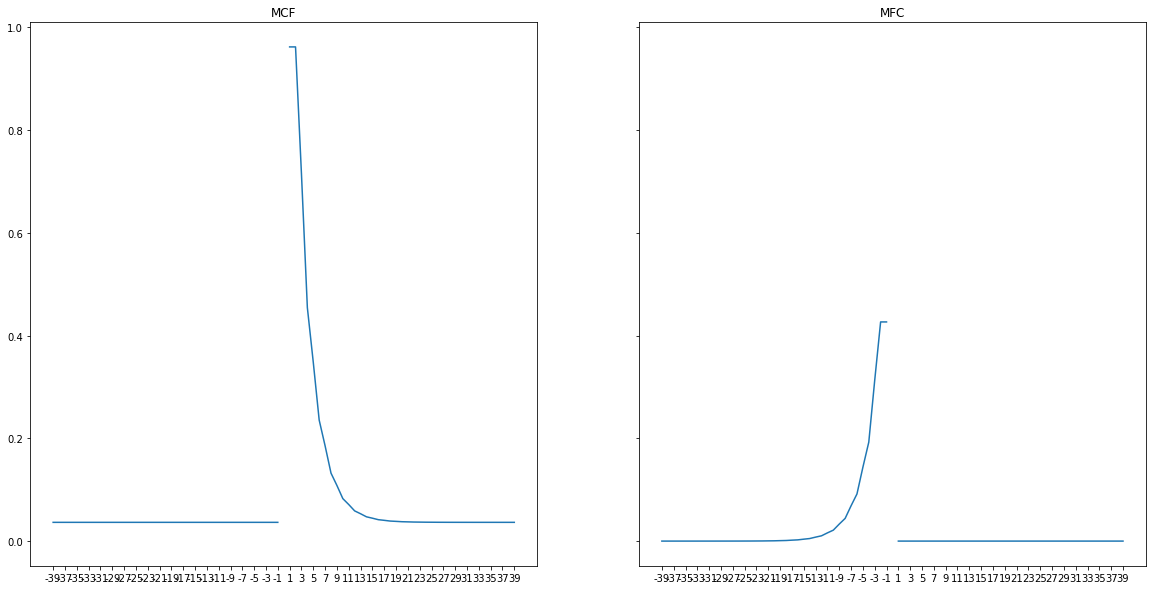

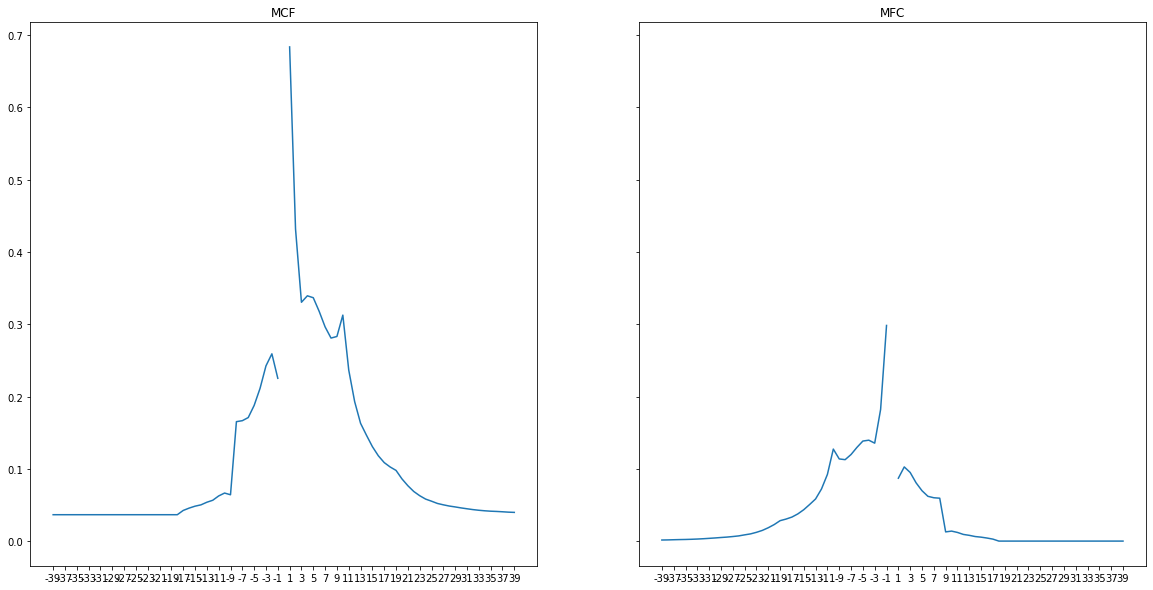

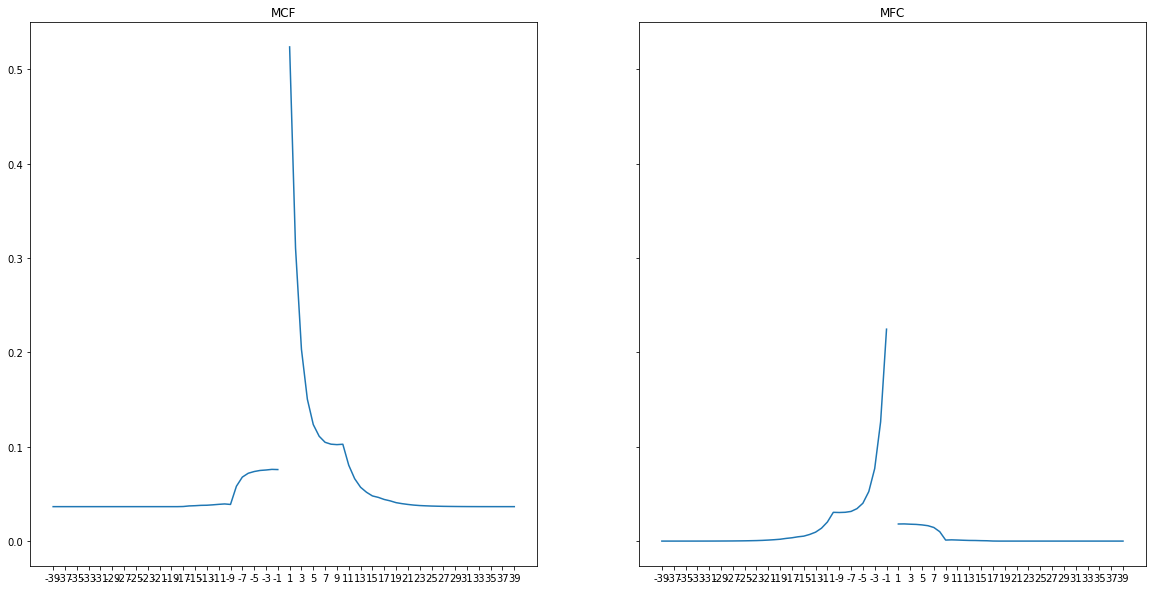

In [ ]:
# configure parameters
model_class = Classic_CMR
model_parameters = cmr_fitted_parameters

# track results
global_lag_range = 39

for list_type in [1, 2, 3, 4]:
    mfc_alternative_connectivities = np.zeros((2, global_lag_range * 2 + 1))
    mcf_alternative_connectivities = np.zeros((2, global_lag_range * 2 + 1))

    # loop through presentations
    for trial_index, presentation in enumerate(presentations[list_types==list_type]):

        # simulate list study
        item_count = np.max(presentation)+1
        model = model_class(item_count, len(presentation), model_parameters)
        model.experience(model.items[presentation])
        lag_range = item_count+1

        # extract item connections
        if model_class.__name__ == 'Classic_CMR':
            mfc_connections = model.mfc[:, 1:-1]
            mcf_connections = model.mcf[1:-1, :]
        else:
            latent_mfc, latent_mcf = latent_mfc_mcf(model)
            mfc_connections = latent_mfc[:, 1:-1]
            mcf_connections = latent_mcf[:, 1:-1]

        # track alternative connectivity
        mfc_alternative_connectivities[0] += mixed_connectivity_by_lag(mfc_connections, presentation)
        mcf_alternative_connectivities[0] += mixed_connectivity_by_lag(mcf_connections, presentation)
        #mfc_alternative_connectivities += alternative_connectivity_by_lag(mfc_connections, presentation)[:, lag_range-3:lag_range+4]
        #mcf_alternative_connectivities += alternative_connectivity_by_lag(mcf_connections, presentation)[:, lag_range-3:lag_range+4]

    # reduce sum to mean
    mfc_alternative_connectivity = mfc_alternative_connectivities / (trial_index+1)
    mcf_alternative_connectivity = mcf_alternative_connectivities / (trial_index+1)
    mfc_alternative_connectivity[:, global_lag_range] = np.nan
    mcf_alternative_connectivity[:, global_lag_range] = np.nan

    # plot results
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 20/2), sharey=True)
    axes[0].plot(np.arange(len(mcf_alternative_connectivity[0])), mcf_alternative_connectivity[0], label='First Presentation')
    #axes[0].plot(np.arange(len(mcf_alternative_connectivity[1])), mcf_alternative_connectivity[1], label='Second Presentation')
    axes[0].set_xticks(np.arange(0, global_lag_range * 2 + 1, 2))
    axes[0].set_xticklabels(np.arange(0, global_lag_range * 2 + 1, 2) - global_lag_range)
    axes[0].set_title('MCF')

    # same for MFC
    axes[1].plot(np.arange(len(mfc_alternative_connectivity[0])), mfc_alternative_connectivity[0], label='First Presentation')
    #axes[1].plot(np.arange(len(mfc_alternative_connectivity[1])), mfc_alternative_connectivity[1], label='Second Presentation')
    axes[1].set_xticks(np.arange(0, global_lag_range * 2 + 1, 2))
    axes[1].set_xticklabels(np.arange(0, global_lag_range * 2 + 1, 2) - global_lag_range)
    axes[1].set_title('MFC')


### TR-CMR

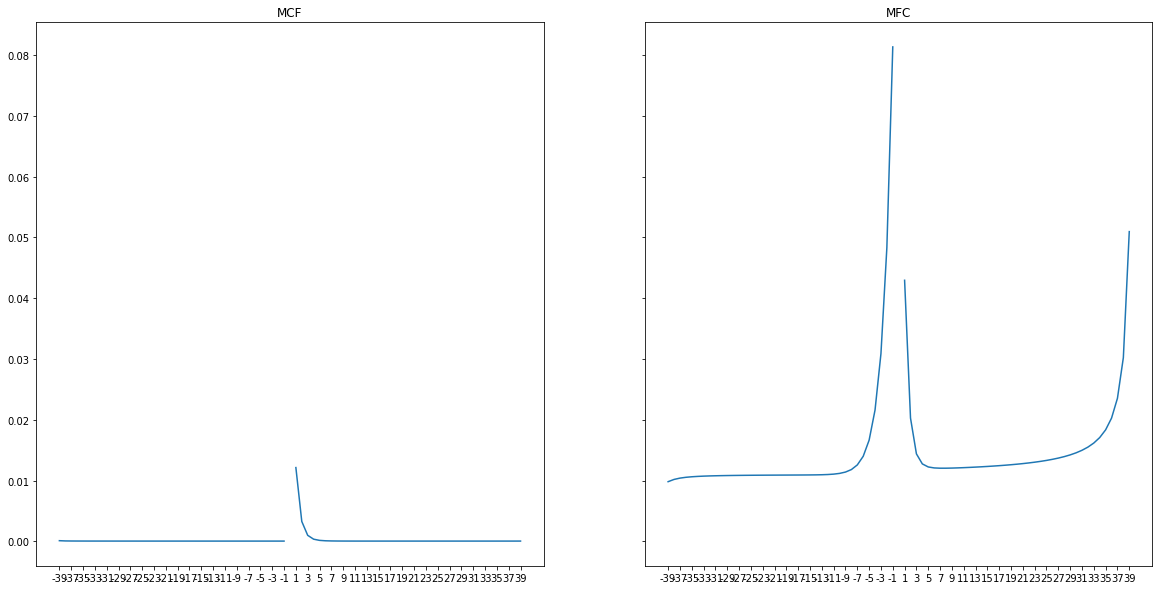

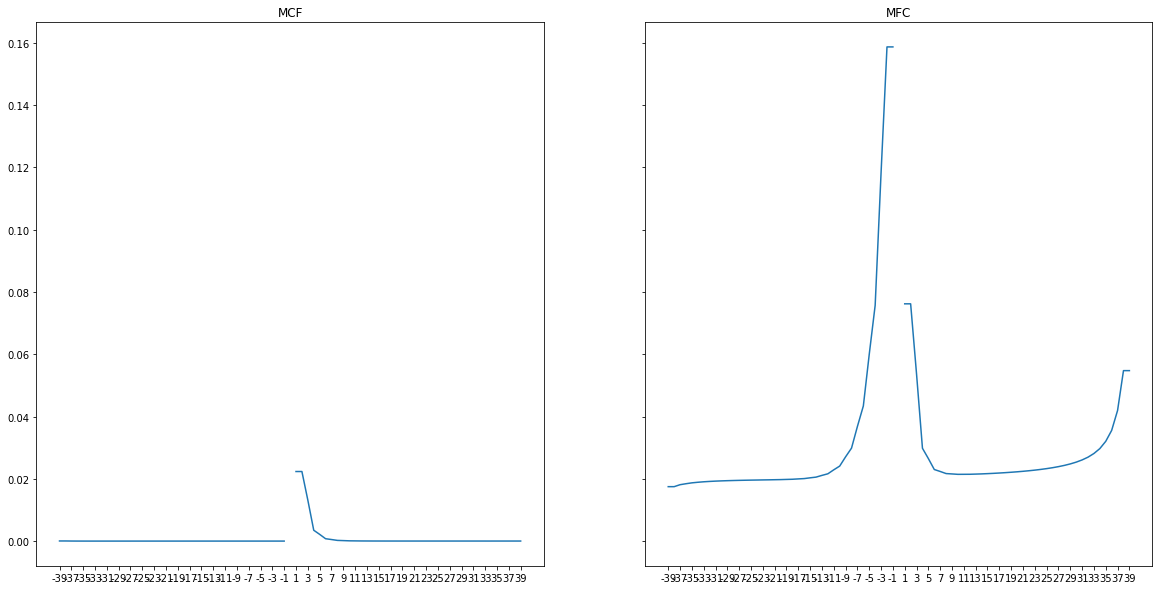

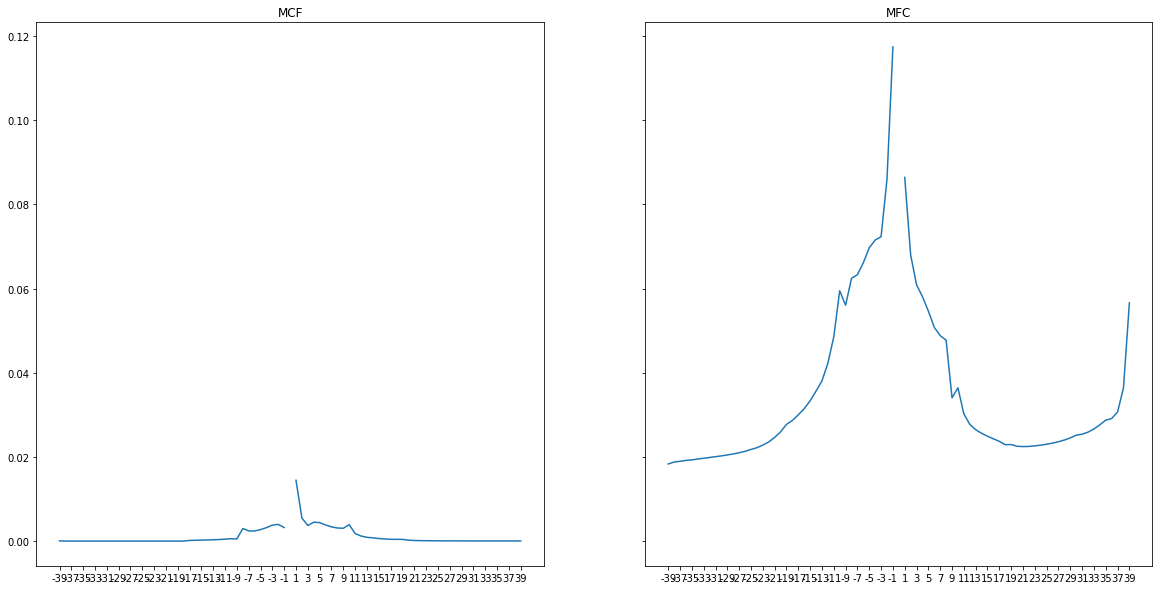

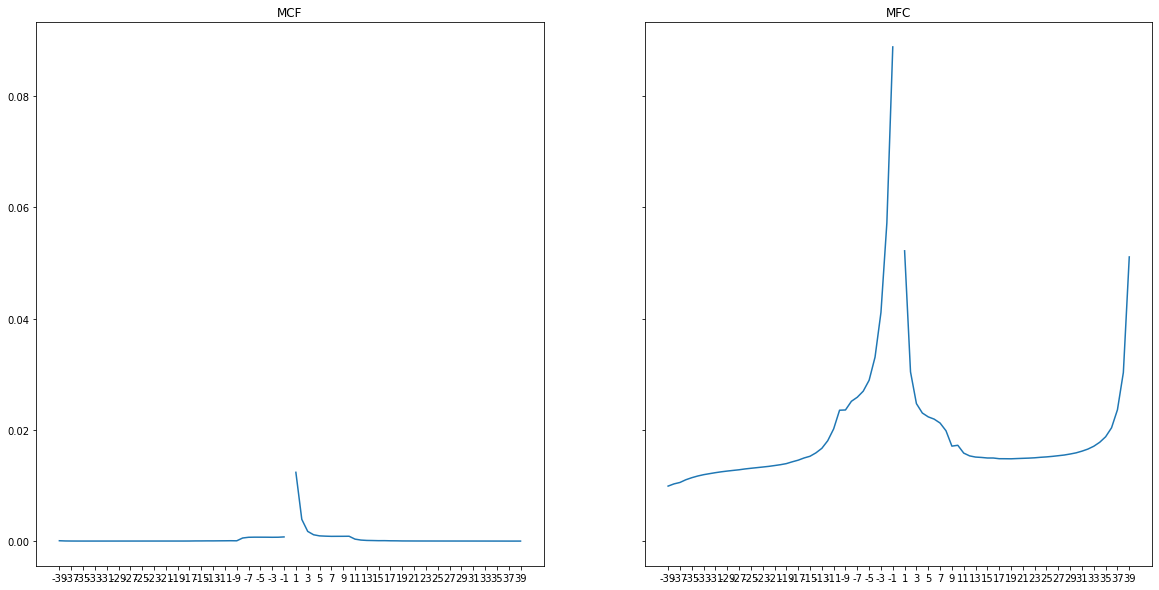

In [ ]:
# configure parameters
model_class = Trace_Reinstatement_CMR
model_parameters = trcmr_fitted_parameters

# track results
global_lag_range = 39

for list_type in [1, 2, 3, 4]:
    mfc_alternative_connectivities = np.zeros((2, global_lag_range * 2 + 1))
    mcf_alternative_connectivities = np.zeros((2, global_lag_range * 2 + 1))

    # loop through presentations
    for trial_index, presentation in enumerate(presentations[list_types==list_type]):

        # simulate list study
        item_count = np.max(presentation)+1
        model = model_class(item_count, len(presentation), model_parameters)
        model.experience(model.items[presentation])
        lag_range = item_count+1

        # extract item connections
        if model_class.__name__ == 'Classic_CMR':
            mfc_connections = model.mfc[:, 1:-1]
            mcf_connections = model.mcf[1:-1, :]
        else:
            latent_mfc, latent_mcf = latent_mfc_mcf(model)
            mfc_connections = latent_mfc[:, 1:-1]
            mcf_connections = latent_mcf[:, 1:-1]

        # track alternative connectivity
        mfc_alternative_connectivities[0] += mixed_connectivity_by_lag(mfc_connections, presentation)
        mcf_alternative_connectivities[0] += mixed_connectivity_by_lag(mcf_connections, presentation)
        #mfc_alternative_connectivities += alternative_connectivity_by_lag(mfc_connections, presentation)[:, lag_range-3:lag_range+4]
        #mcf_alternative_connectivities += alternative_connectivity_by_lag(mcf_connections, presentation)[:, lag_range-3:lag_range+4]

    # reduce sum to mean
    mfc_alternative_connectivity = mfc_alternative_connectivities / (trial_index+1)
    mcf_alternative_connectivity = mcf_alternative_connectivities / (trial_index+1)
    mfc_alternative_connectivity[:, global_lag_range] = np.nan
    mcf_alternative_connectivity[:, global_lag_range] = np.nan

    # plot results
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 20/2), sharey=True)
    axes[0].plot(np.arange(len(mcf_alternative_connectivity[0])), mcf_alternative_connectivity[0], label='First Presentation')
    #axes[0].plot(np.arange(len(mcf_alternative_connectivity[1])), mcf_alternative_connectivity[1], label='Second Presentation')
    axes[0].set_xticks(np.arange(0, global_lag_range * 2 + 1, 2))
    axes[0].set_xticklabels(np.arange(0, global_lag_range * 2 + 1, 2) - global_lag_range)
    axes[0].set_title('MCF')

    # same for MFC
    axes[1].plot(np.arange(len(mfc_alternative_connectivity[0])), mfc_alternative_connectivity[0], label='First Presentation')
    #axes[1].plot(np.arange(len(mfc_alternative_connectivity[1])), mfc_alternative_connectivity[1], label='Second Presentation')
    axes[1].set_xticks(np.arange(0, global_lag_range * 2 + 1, 2))
    axes[1].set_xticklabels(np.arange(0, global_lag_range * 2 + 1, 2) - global_lag_range)
    axes[1].set_title('MFC')


## Alternative Lag-Connectivity

### InstanceCMR

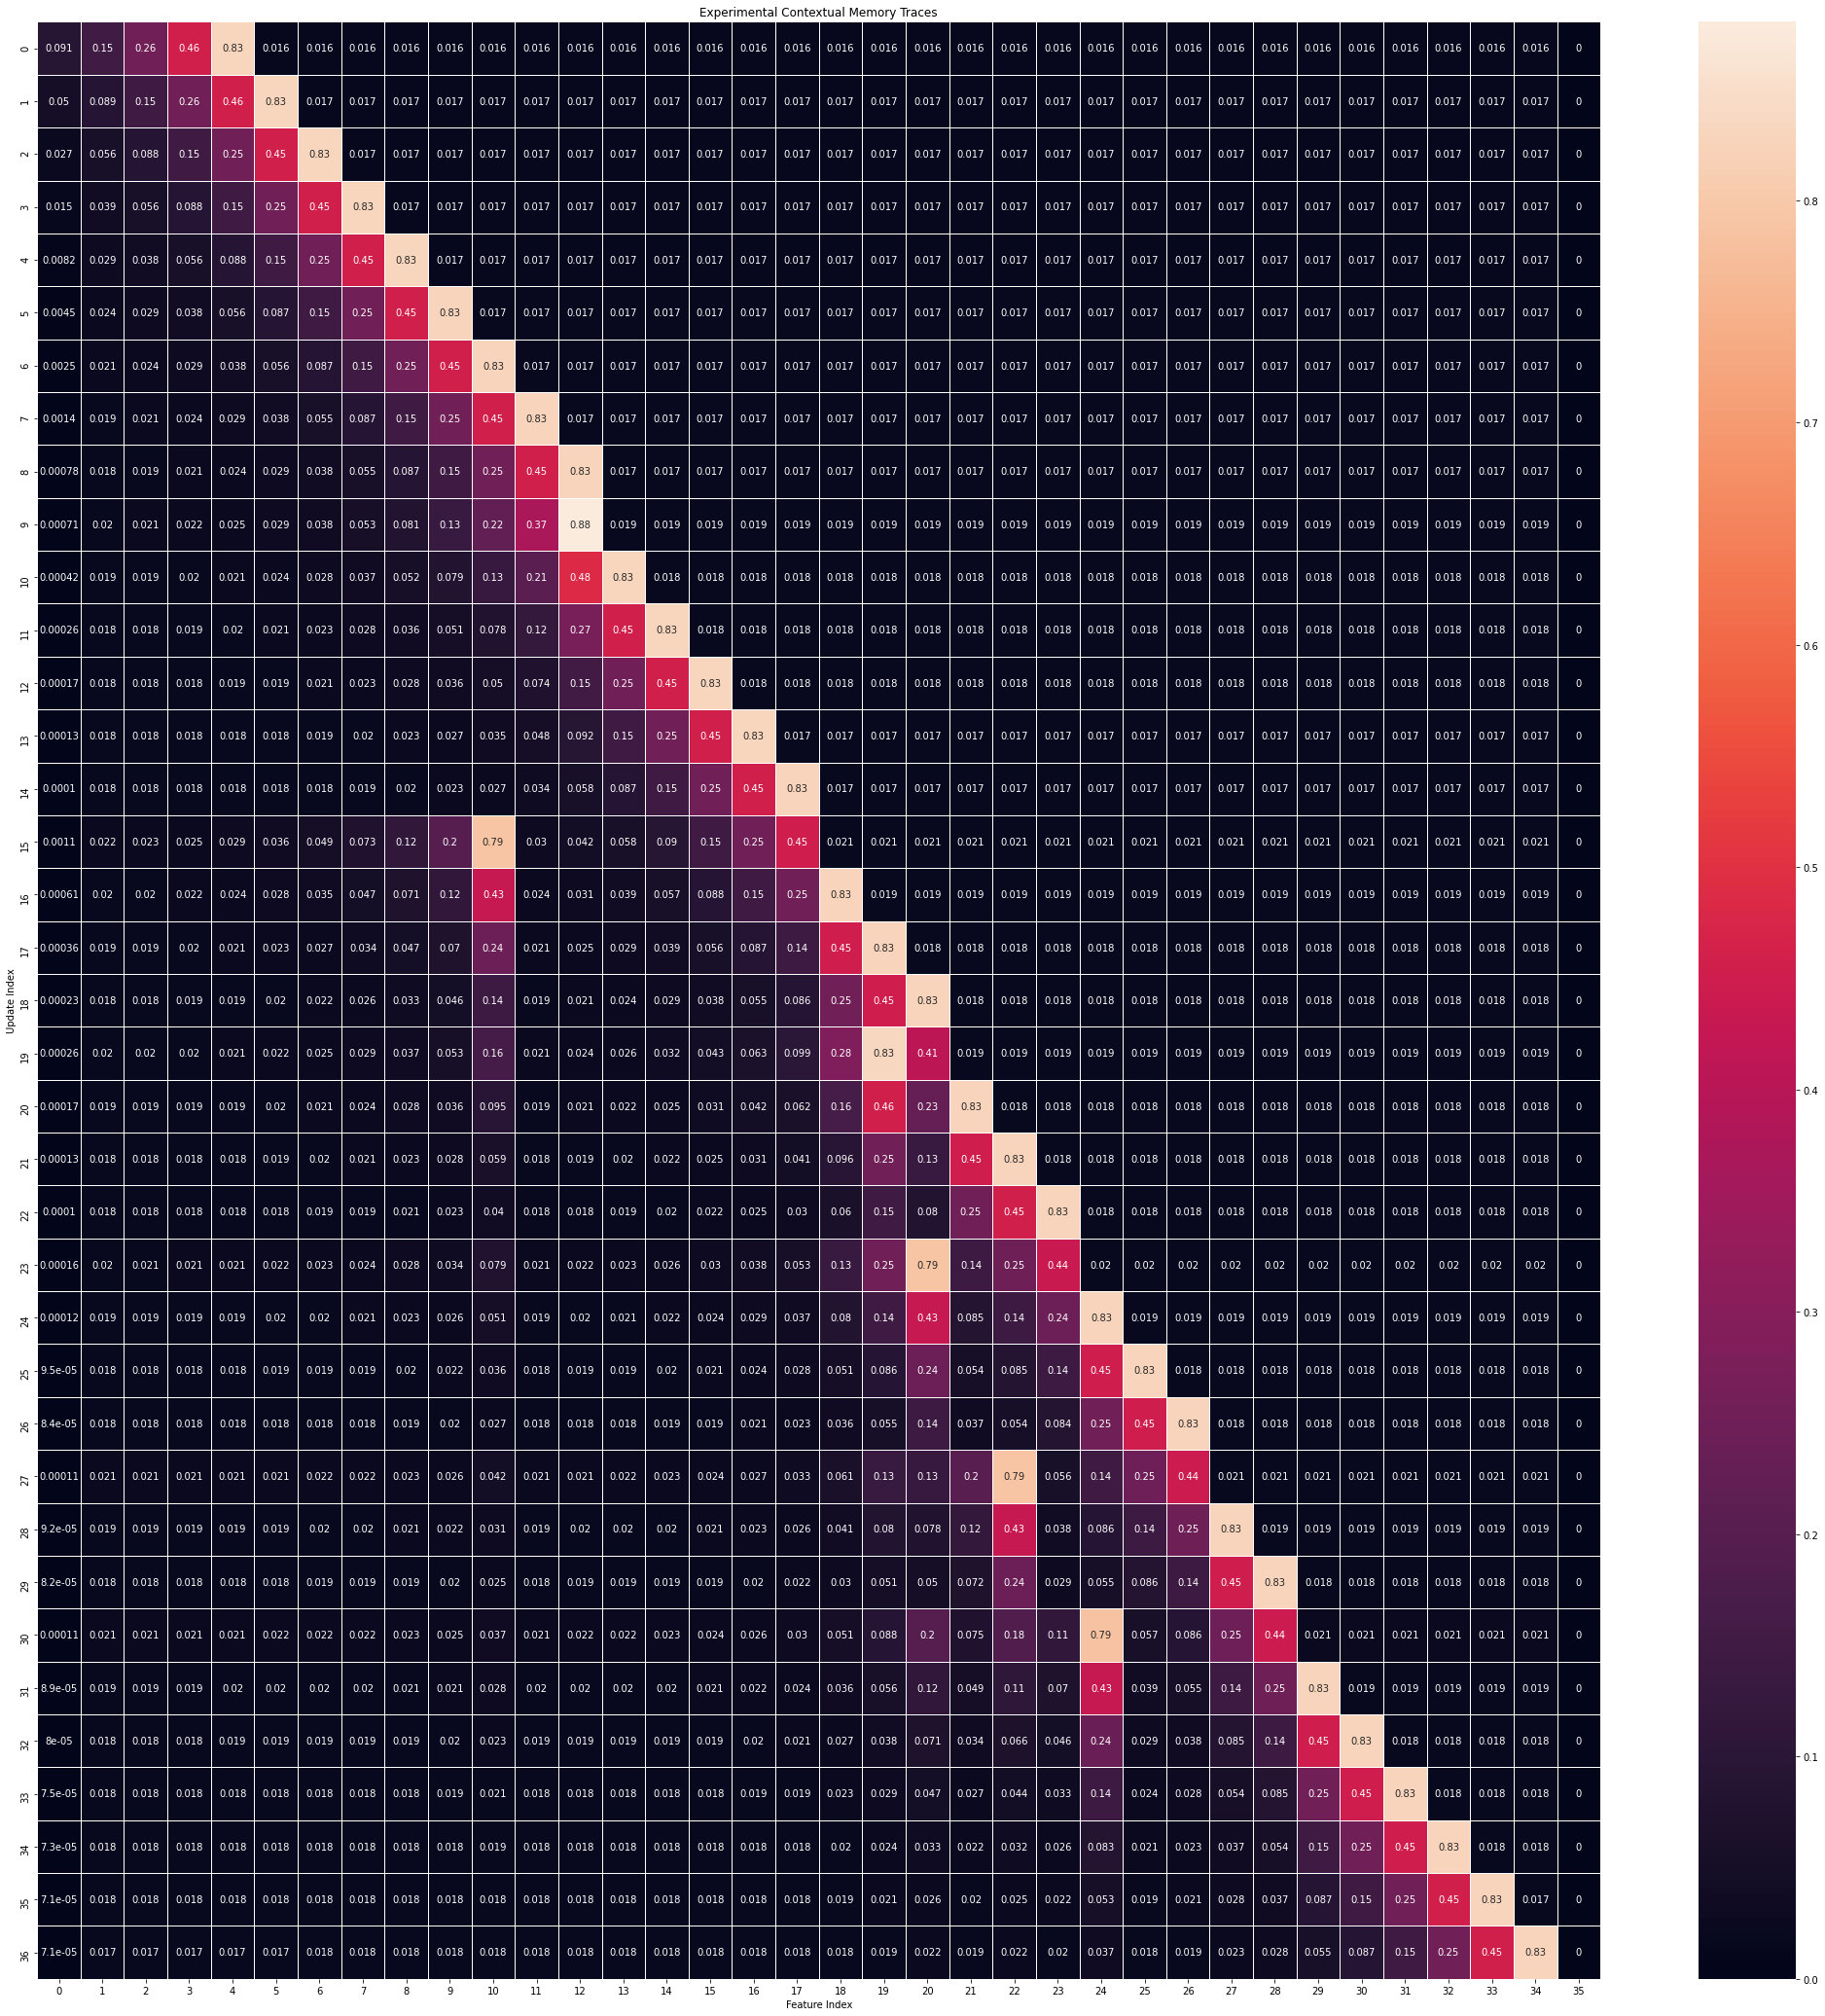

[ 0  1  2  3  4  5  6  7  8  9 10 11 11 12 13 14 15 16  9 17 18 19 18 20
 21 22 19 23 24 25 21 26 27 23 28 29 30 31 32 33]


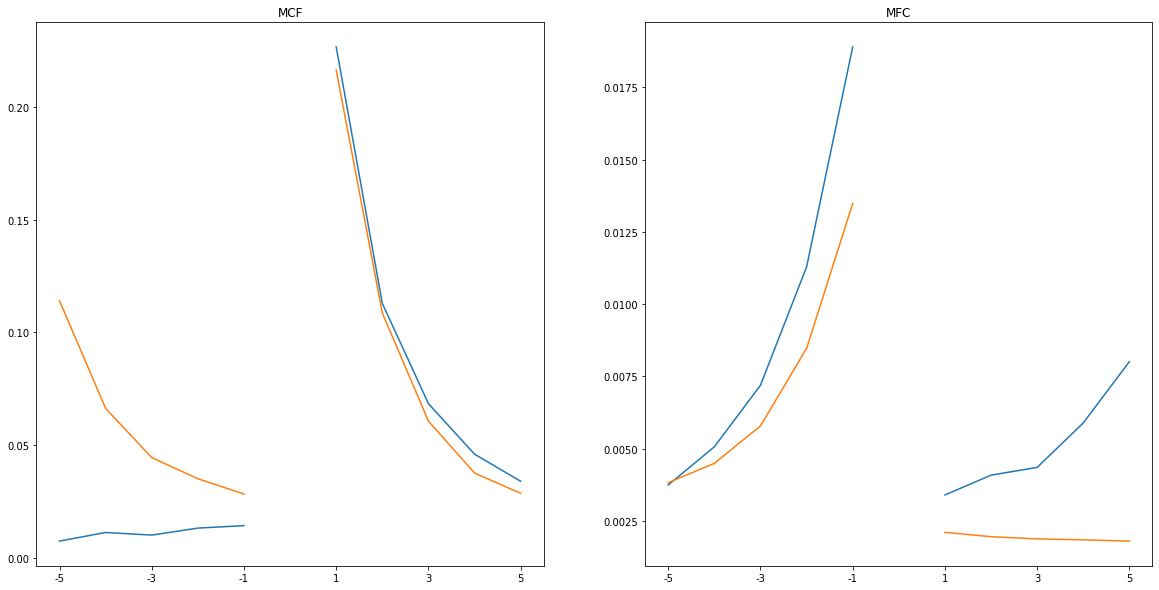

In [ ]:
# configure parameters
model_class = Instance_CMR
model_parameters = icmr_fitted_parameters

# track results
global_lag_range = 39

for list_type in [4]:
    mfc_alternative_connectivities = np.zeros((2, global_lag_range * 2 + 1))
    mcf_alternative_connectivities = np.zeros((2, global_lag_range * 2 + 1))

    # loop through presentations
    for trial_index, presentation in enumerate(presentations[list_types==list_type]):

        # simulate list study
        item_count = np.max(presentation)+1
        model = model_class(item_count, len(presentation), model_parameters)
        model.experience(model.items[presentation])

        # extract item connections
        if model_class.__name__ == 'Classic_CMR':
            mfc_connections = model.mfc[:, 1:-1]
            mcf_connections = model.mcf[1:-1, :]
            if trial_index == 0:
                mfc_heatmap(model.mfc)
                mfc_heatmap(model.mcf)
                print(presentation)
        else:
            latent_mfc, latent_mcf = latent_mfc_mcf(model)
            mfc_connections = latent_mfc[:, 1:-1]
            mcf_connections = latent_mcf[:, 1:-1]
            if trial_index == 0:
                icmr_memory_heatmap(model, just_experimental=True, just_context=True)
                print(presentation)

        # track alternative connectivity
        mfc_alternative_connectivities += alternative_connectivity_by_lag(mfc_connections, presentation)
        mcf_alternative_connectivities += alternative_connectivity_by_lag(mcf_connections, presentation)

    # reduce sum to mean
    mfc_alternative_connectivity = mfc_alternative_connectivities / (trial_index+1)
    mcf_alternative_connectivity = mcf_alternative_connectivities / (trial_index+1)
    mfc_alternative_connectivity[:, global_lag_range] = np.nan
    mcf_alternative_connectivity[:, global_lag_range] = np.nan

    # focus on +/- 3 lags
    plotting_lag_range = 5
    mfc_alternative_connectivity = mfc_alternative_connectivity[:, global_lag_range-plotting_lag_range:global_lag_range+plotting_lag_range+1]
    mcf_alternative_connectivity = mcf_alternative_connectivity[:, global_lag_range-plotting_lag_range:global_lag_range+plotting_lag_range+1]

    # plot results
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 20/2), sharey=False)
    axes[0].plot(np.arange(len(mcf_alternative_connectivity[0])), mcf_alternative_connectivity[0], label='First Presentation')
    axes[0].plot(np.arange(len(mcf_alternative_connectivity[1])), mcf_alternative_connectivity[1], label='Second Presentation')
    axes[0].set_xticks(np.arange(0, plotting_lag_range * 2 + 1, 2))
    axes[0].set_xticklabels(np.arange(0, plotting_lag_range * 2 + 1, 2) - plotting_lag_range)
    axes[0].set_title('MCF')

    # same for MFC
    axes[1].plot(np.arange(len(mfc_alternative_connectivity[0])), mfc_alternative_connectivity[0], label='First Presentation')
    axes[1].plot(np.arange(len(mfc_alternative_connectivity[1])), mfc_alternative_connectivity[1], label='Second Presentation')
    axes[1].set_xticks(np.arange(0, plotting_lag_range * 2 + 1, 2))
    axes[1].set_xticklabels(np.arange(0, plotting_lag_range * 2 + 1, 2) - plotting_lag_range)
    axes[1].set_title('MFC')


### Classic CMR

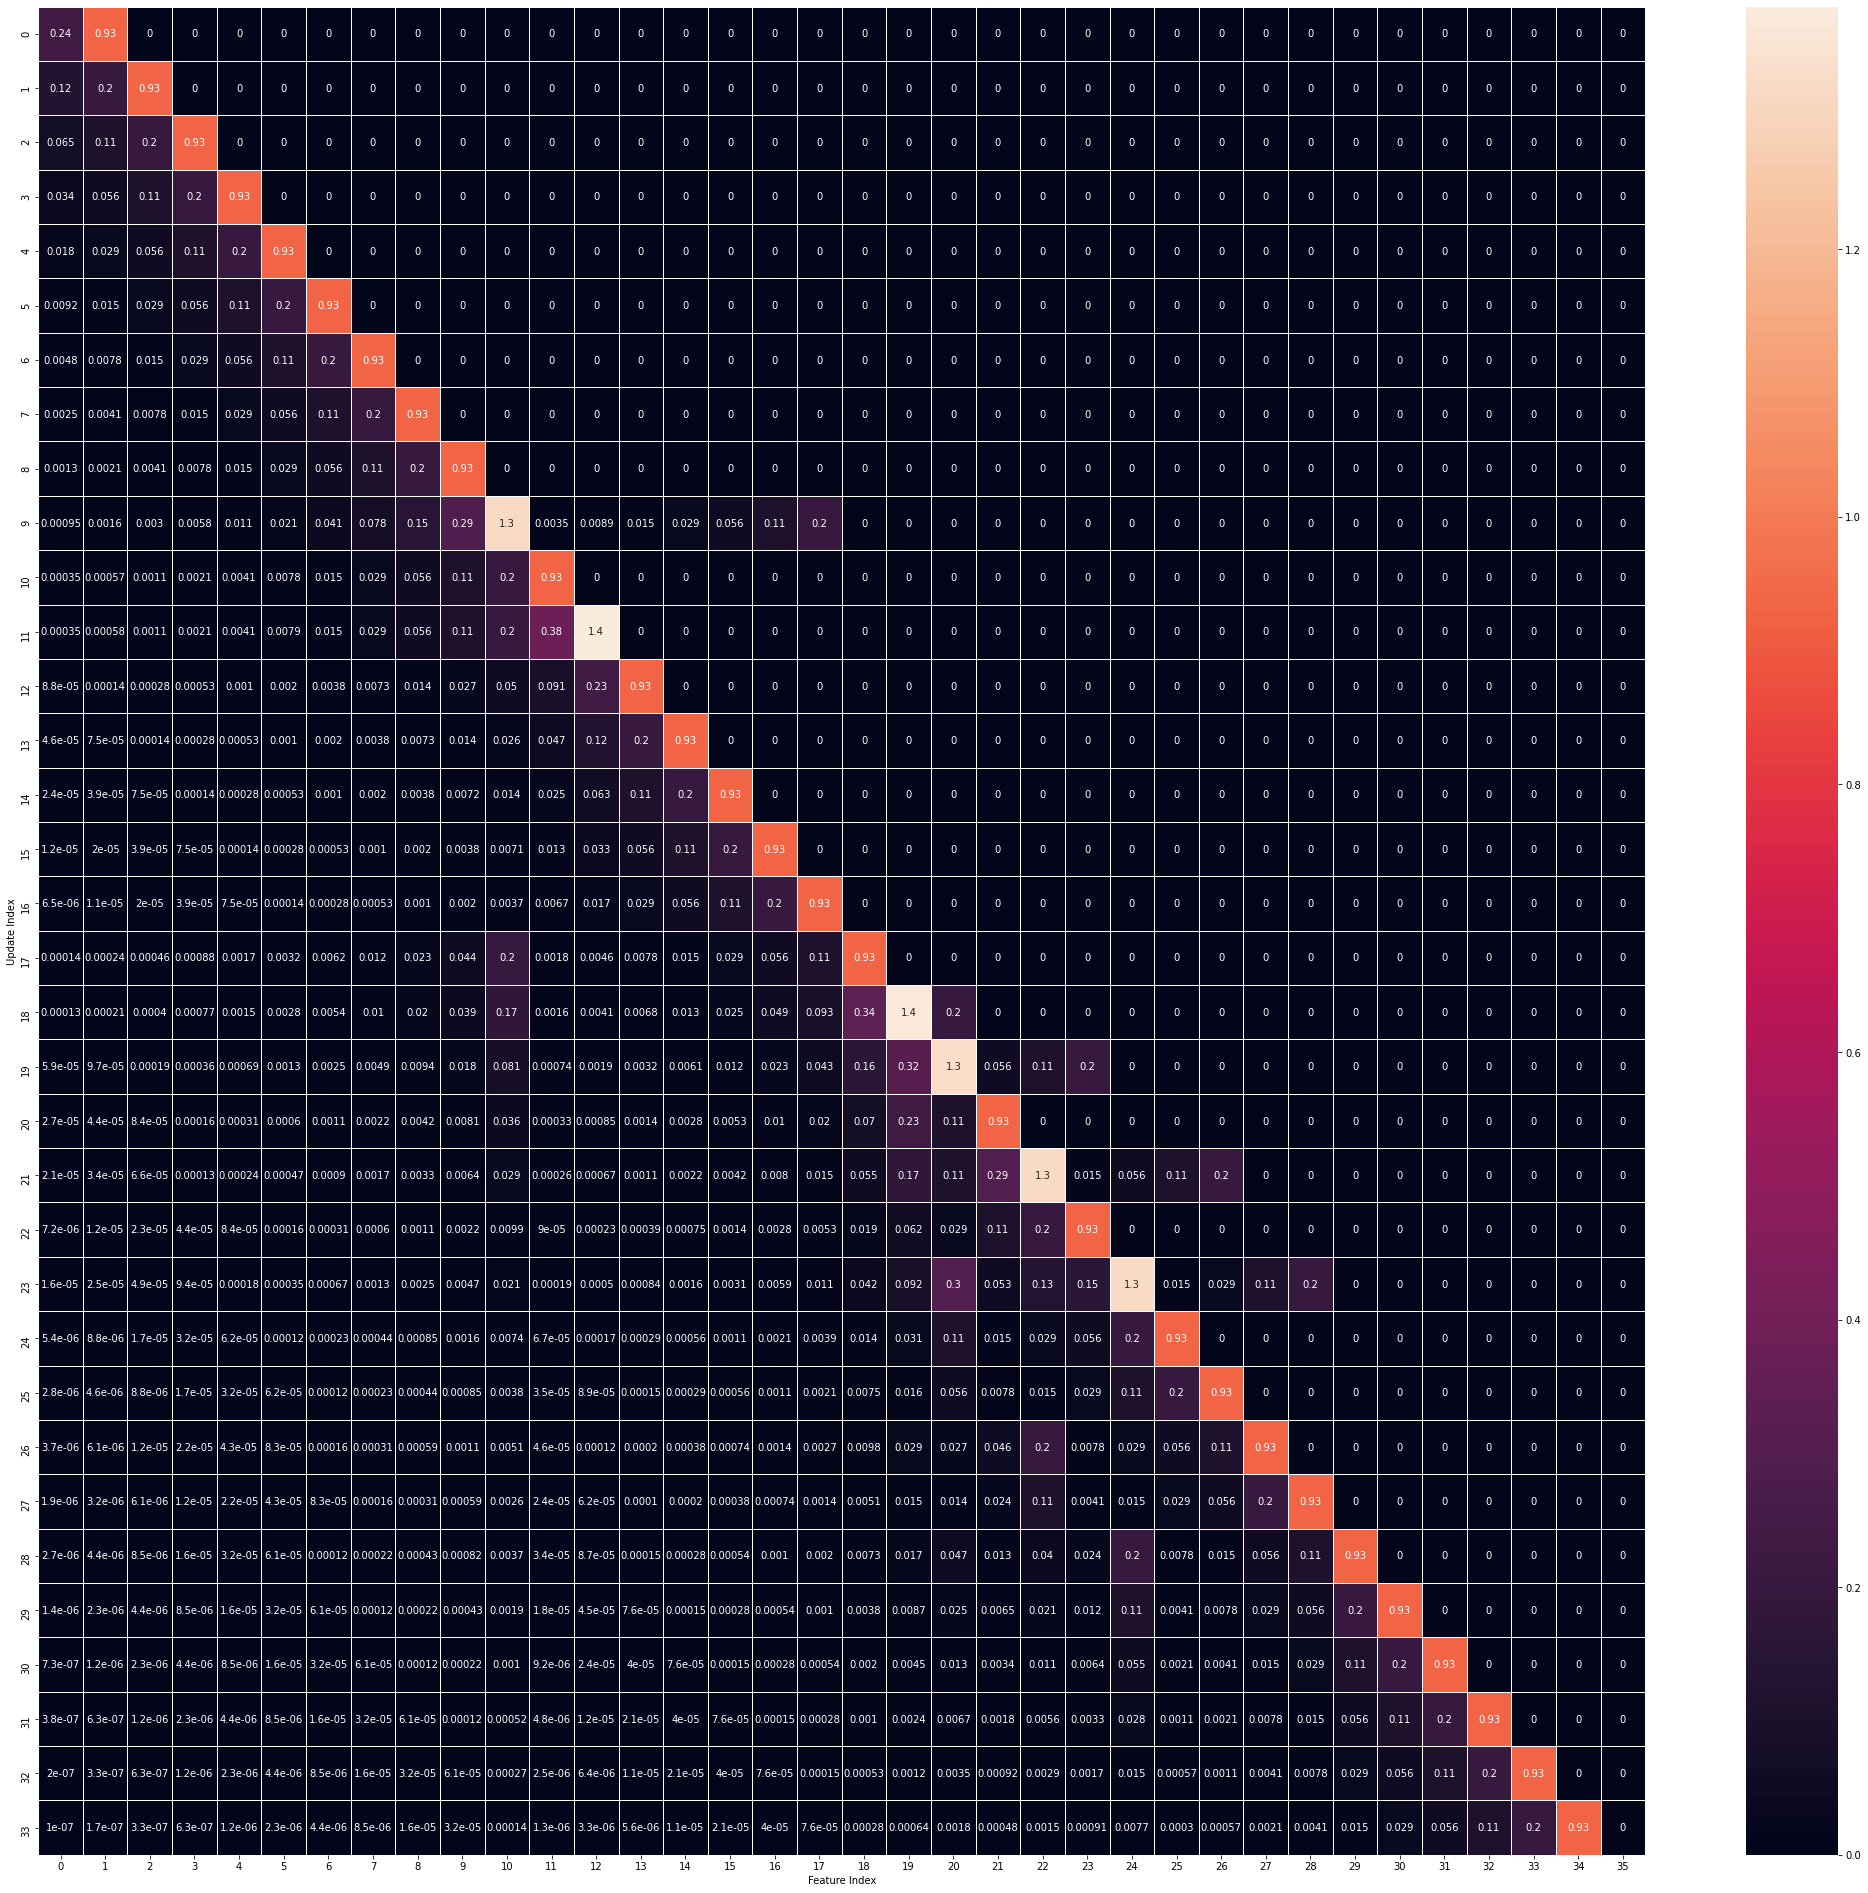

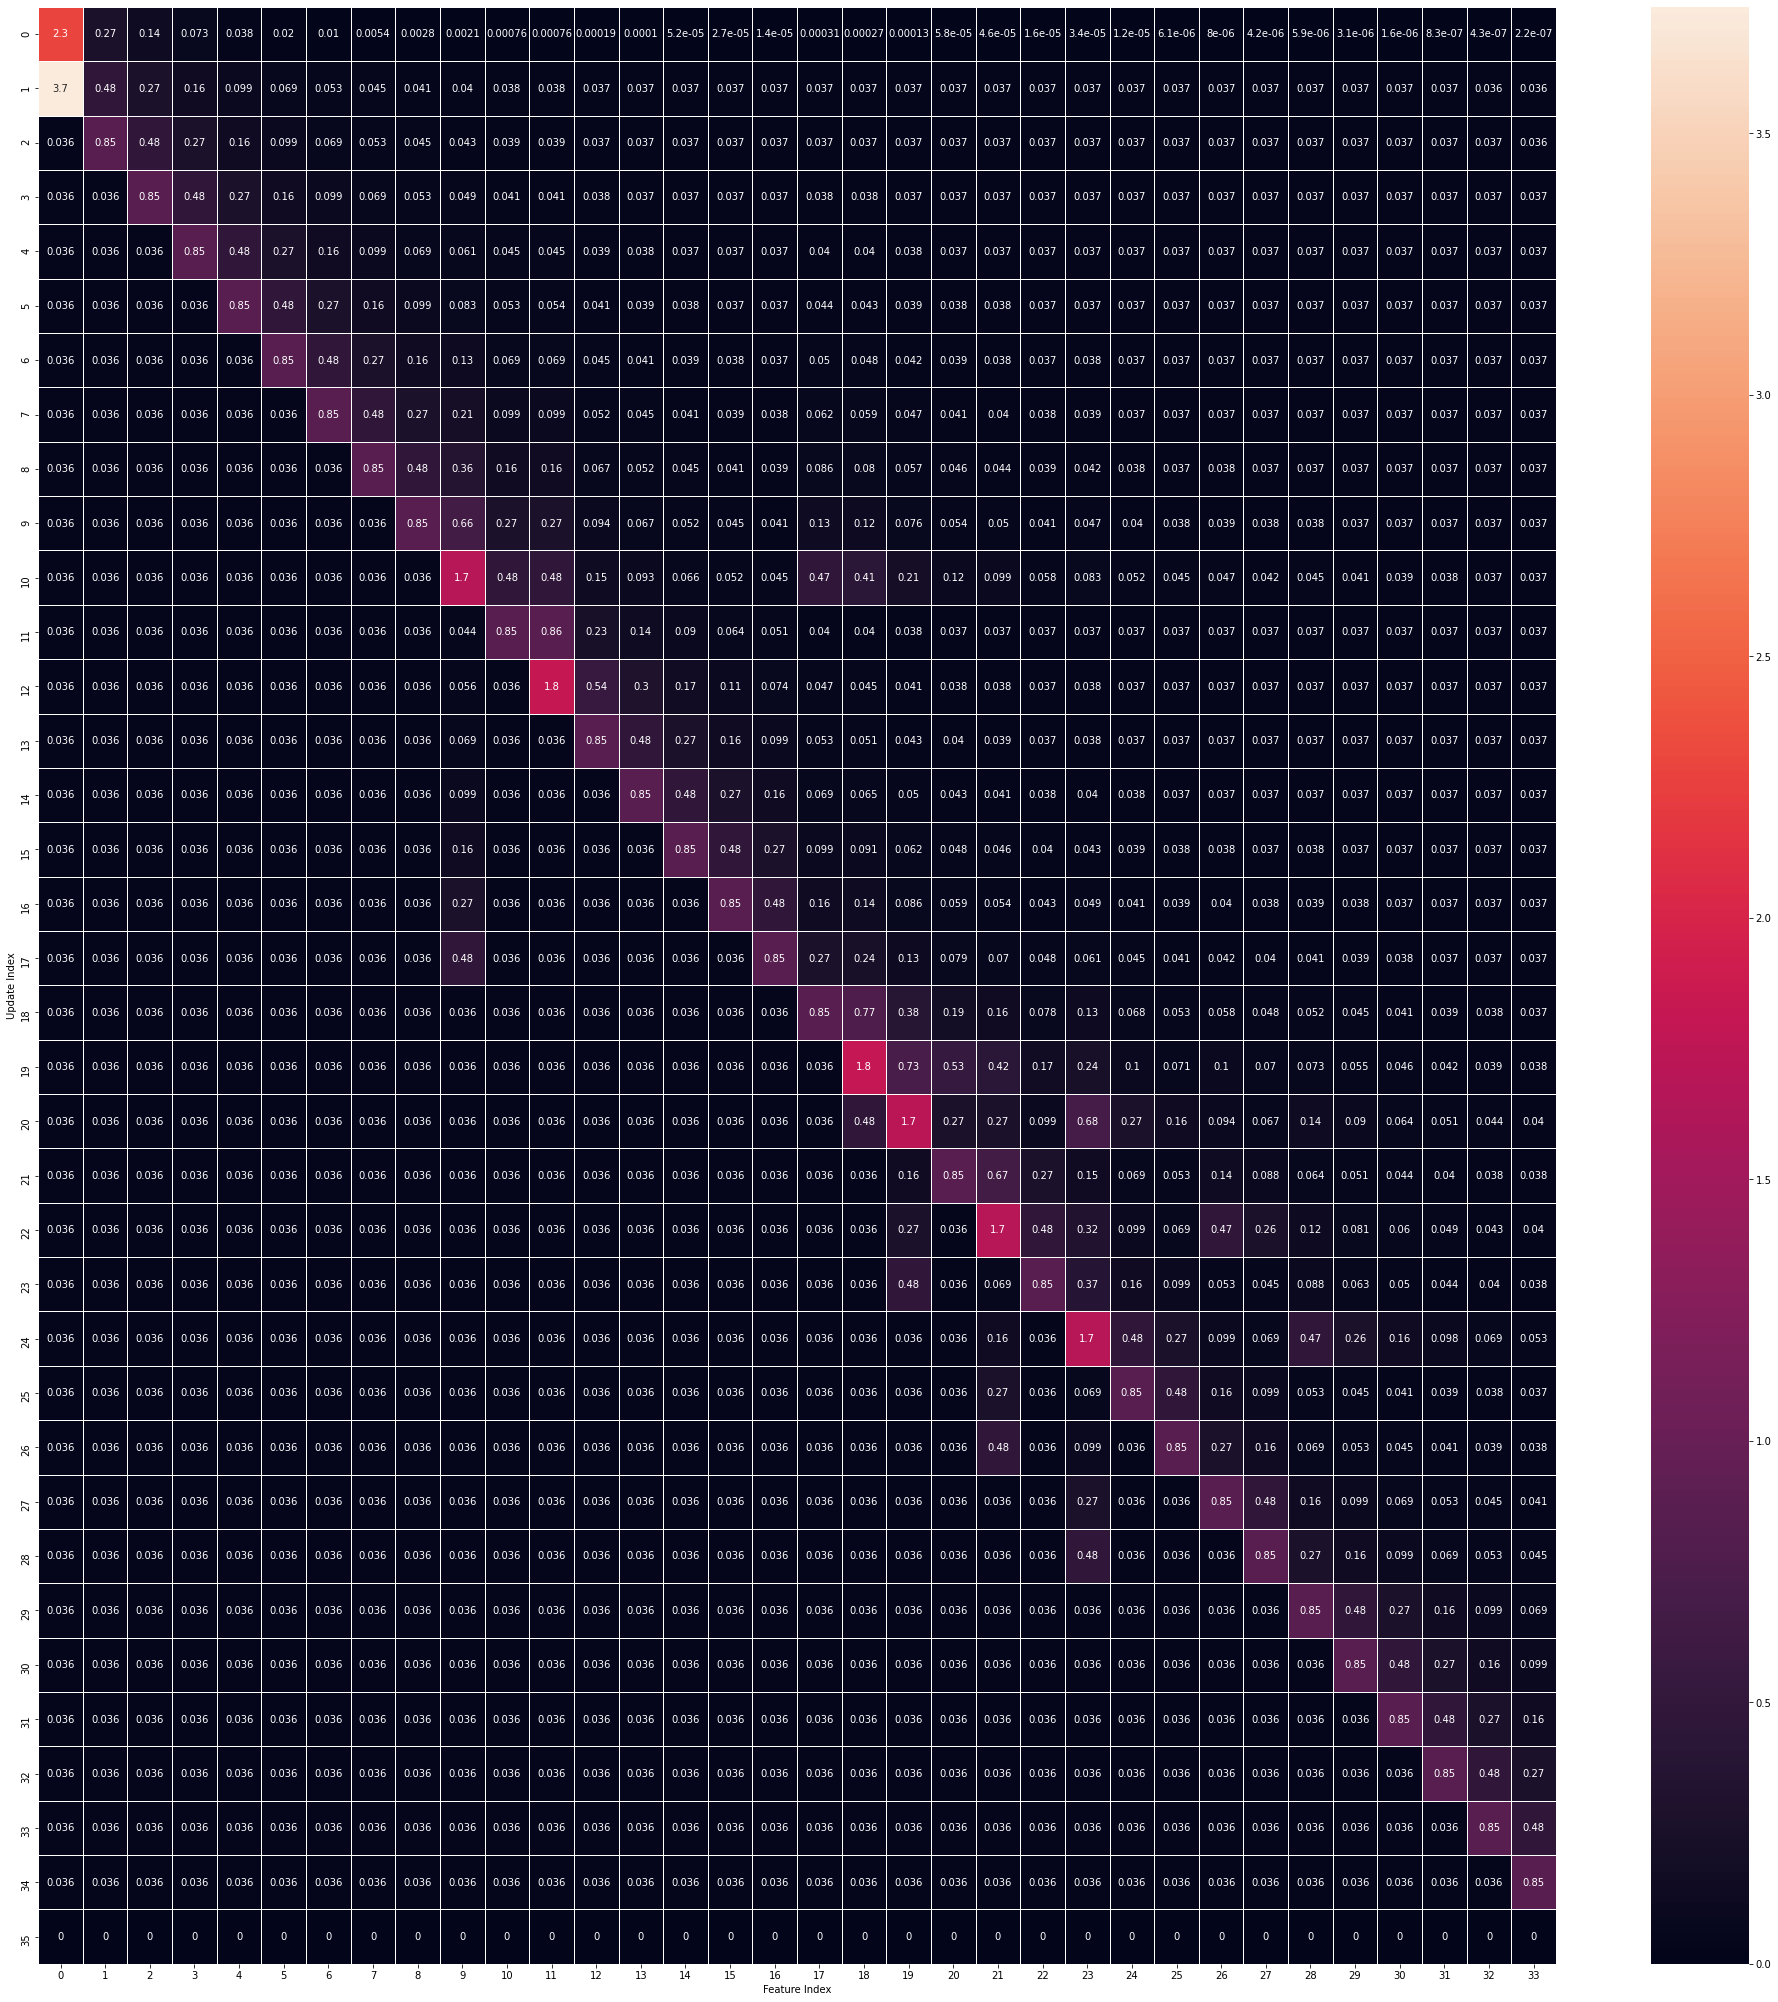

[ 0  1  2  3  4  5  6  7  8  9 10 11 11 12 13 14 15 16  9 17 18 19 18 20
 21 22 19 23 24 25 21 26 27 23 28 29 30 31 32 33]


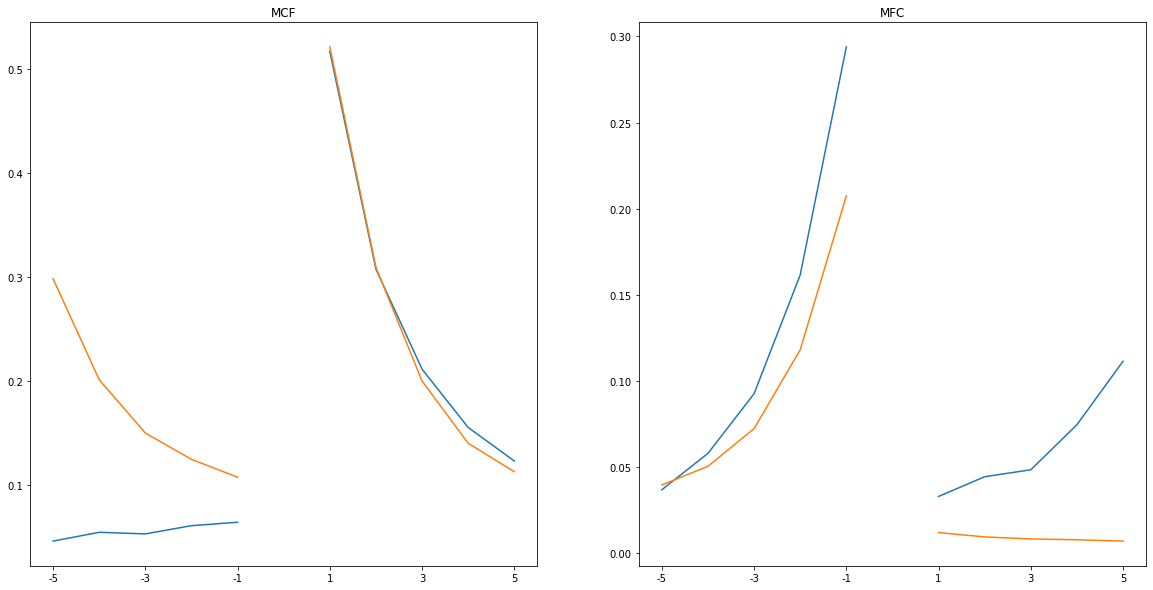

In [ ]:
# configure parameters
model_class = Classic_CMR
model_parameters = cmr_fitted_parameters

# track results
global_lag_range = 39

for list_type in [4]:
    mfc_alternative_connectivities = np.zeros((2, global_lag_range * 2 + 1))
    mcf_alternative_connectivities = np.zeros((2, global_lag_range * 2 + 1))

    # loop through presentations
    for trial_index, presentation in enumerate(presentations[list_types==list_type]):

        # simulate list study
        item_count = np.max(presentation)+1
        model = model_class(item_count, len(presentation), model_parameters)
        model.experience(model.items[presentation])

        # extract item connections
        if model_class.__name__ == 'Classic_CMR':
            mfc_connections = model.mfc[:, 1:-1]
            mcf_connections = model.mcf[1:-1, :]
            if trial_index == 0:
                mfc_heatmap(model.mfc)
                mfc_heatmap(model.mcf)
                print(presentation)
        else:
            latent_mfc, latent_mcf = latent_mfc_mcf(model)
            mfc_connections = latent_mfc[:, 1:-1]
            mcf_connections = latent_mcf[:, 1:-1]
            if trial_index == 0:
                icmr_memory_heatmap(model, just_experimental=True, just_context=True)
                print(presentation)

        # track alternative connectivity
        mfc_alternative_connectivities += alternative_connectivity_by_lag(mfc_connections, presentation)
        mcf_alternative_connectivities += alternative_connectivity_by_lag(mcf_connections, presentation)

    # reduce sum to mean
    mfc_alternative_connectivity = mfc_alternative_connectivities / (trial_index+1)
    mcf_alternative_connectivity = mcf_alternative_connectivities / (trial_index+1)
    mfc_alternative_connectivity[:, global_lag_range] = np.nan
    mcf_alternative_connectivity[:, global_lag_range] = np.nan

    # focus on +/- 3 lags
    plotting_lag_range = 5
    mfc_alternative_connectivity = mfc_alternative_connectivity[:, global_lag_range-plotting_lag_range:global_lag_range+plotting_lag_range+1]
    mcf_alternative_connectivity = mcf_alternative_connectivity[:, global_lag_range-plotting_lag_range:global_lag_range+plotting_lag_range+1]

    # plot results
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 20/2), sharey=False)
    axes[0].plot(np.arange(len(mcf_alternative_connectivity[0])), mcf_alternative_connectivity[0], label='First Presentation')
    axes[0].plot(np.arange(len(mcf_alternative_connectivity[1])), mcf_alternative_connectivity[1], label='Second Presentation')
    axes[0].set_xticks(np.arange(0, plotting_lag_range * 2 + 1, 2))
    axes[0].set_xticklabels(np.arange(0, plotting_lag_range * 2 + 1, 2) - plotting_lag_range)
    axes[0].set_title('MCF')

    # same for MFC
    axes[1].plot(np.arange(len(mfc_alternative_connectivity[0])), mfc_alternative_connectivity[0], label='First Presentation')
    axes[1].plot(np.arange(len(mfc_alternative_connectivity[1])), mfc_alternative_connectivity[1], label='Second Presentation')
    axes[1].set_xticks(np.arange(0, plotting_lag_range * 2 + 1, 2))
    axes[1].set_xticklabels(np.arange(0, plotting_lag_range * 2 + 1, 2) - plotting_lag_range)
    axes[1].set_title('MFC')


### TR-CMR

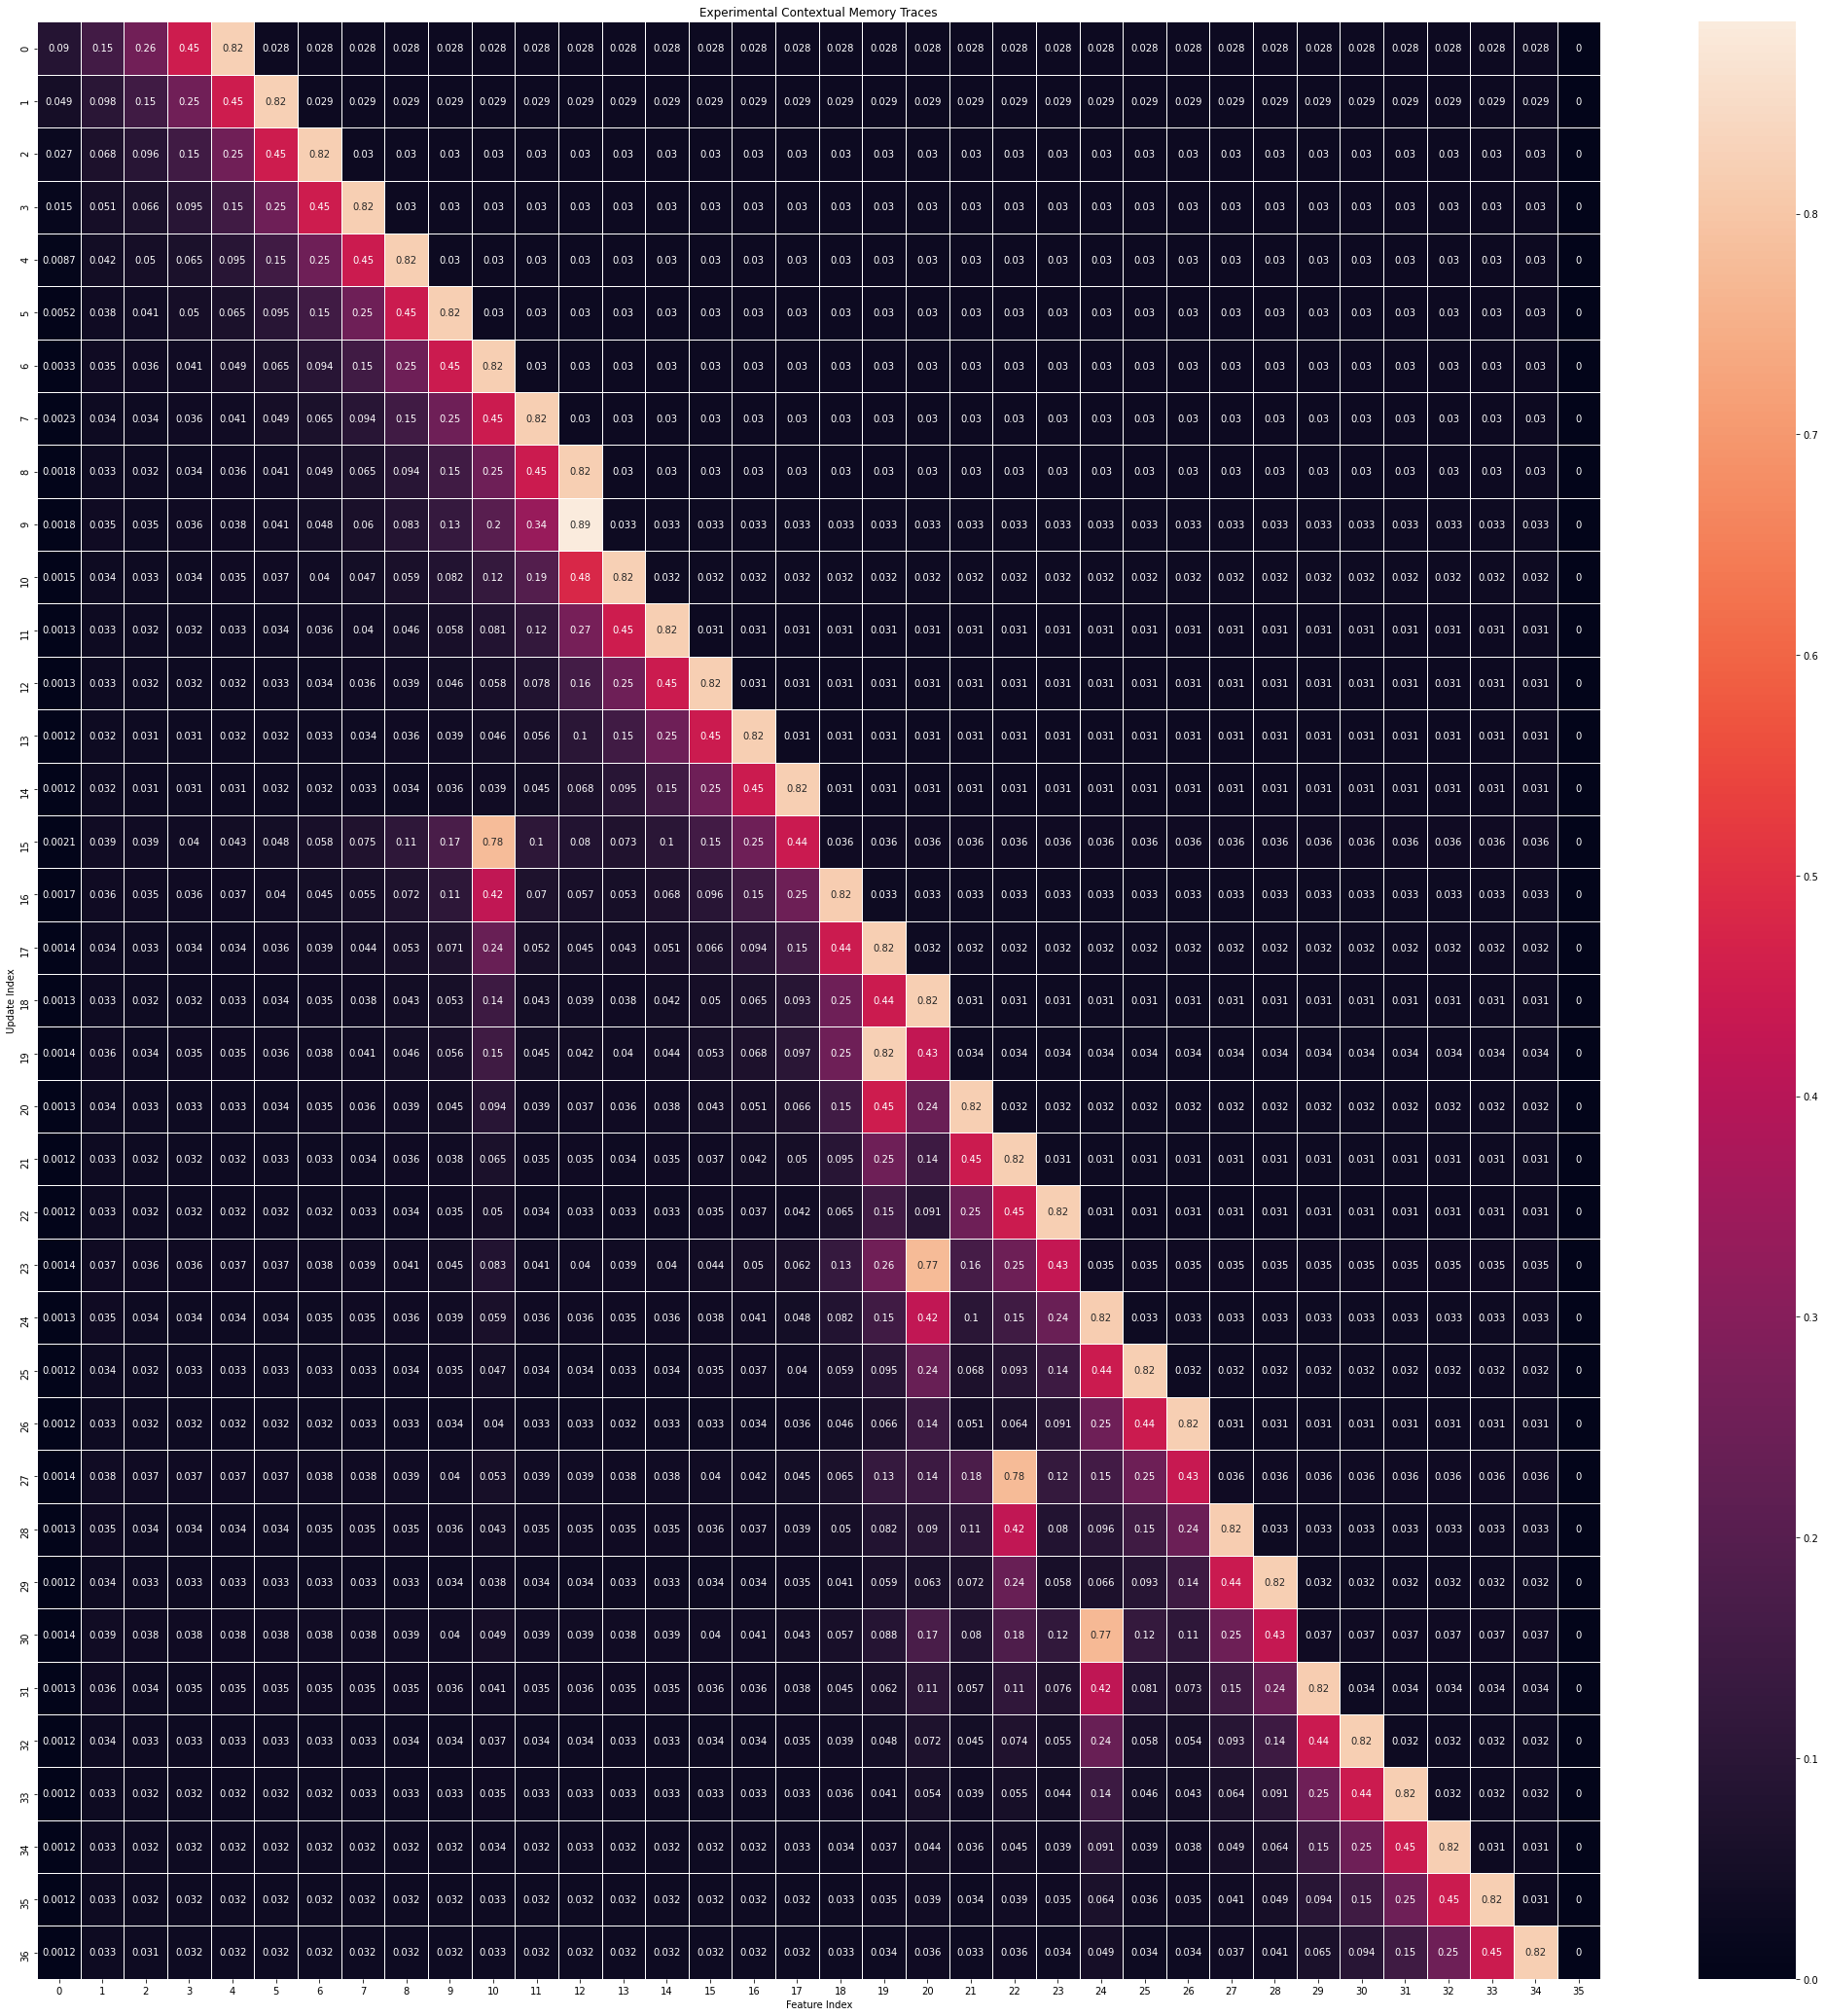

[ 0  1  2  3  4  5  6  7  8  9 10 11 11 12 13 14 15 16  9 17 18 19 18 20
 21 22 19 23 24 25 21 26 27 23 28 29 30 31 32 33]


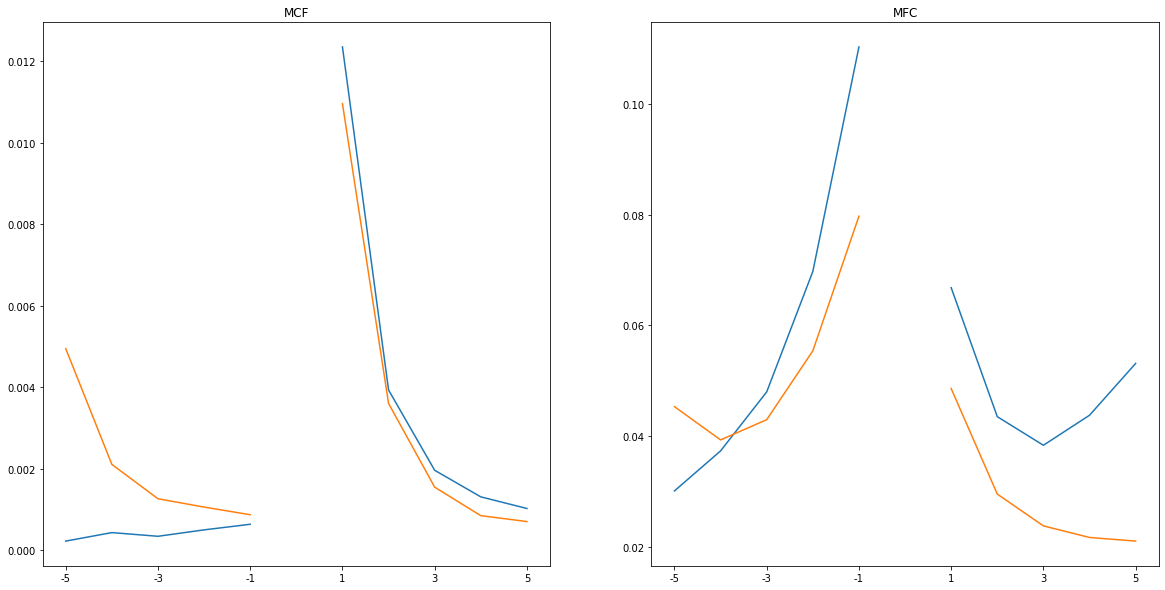

In [ ]:
# configure parameters
model_class = Trace_Reinstatement_CMR
model_parameters = trcmr_fitted_parameters

# track results
global_lag_range = 39

for list_type in [4]:
    mfc_alternative_connectivities = np.zeros((2, global_lag_range * 2 + 1))
    mcf_alternative_connectivities = np.zeros((2, global_lag_range * 2 + 1))

    # loop through presentations
    for trial_index, presentation in enumerate(presentations[list_types==list_type]):

        # simulate list study
        item_count = np.max(presentation)+1
        model = model_class(item_count, len(presentation), model_parameters)
        model.experience(model.items[presentation])

        # extract item connections
        if model_class.__name__ == 'Classic_CMR':
            mfc_connections = model.mfc[:, 1:-1]
            mcf_connections = model.mcf[1:-1, :]
            if trial_index == 0:
                mfc_heatmap(model.mfc)
                mfc_heatmap(model.mcf)
                print(presentation)
        else:
            latent_mfc, latent_mcf = latent_mfc_mcf(model)
            mfc_connections = latent_mfc[:, 1:-1]
            mcf_connections = latent_mcf[:, 1:-1]
            if trial_index == 0:
                icmr_memory_heatmap(model, just_experimental=True, just_context=True)
                print(presentation)

        # track alternative connectivity
        mfc_alternative_connectivities += alternative_connectivity_by_lag(mfc_connections, presentation)
        mcf_alternative_connectivities += alternative_connectivity_by_lag(mcf_connections, presentation)

    # reduce sum to mean
    mfc_alternative_connectivity = mfc_alternative_connectivities / (trial_index+1)
    mcf_alternative_connectivity = mcf_alternative_connectivities / (trial_index+1)
    mfc_alternative_connectivity[:, global_lag_range] = np.nan
    mcf_alternative_connectivity[:, global_lag_range] = np.nan

    # focus on +/- 3 lags
    plotting_lag_range = 5
    mfc_alternative_connectivity = mfc_alternative_connectivity[:, global_lag_range-plotting_lag_range:global_lag_range+plotting_lag_range+1]
    mcf_alternative_connectivity = mcf_alternative_connectivity[:, global_lag_range-plotting_lag_range:global_lag_range+plotting_lag_range+1]

    # plot results
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 20/2), sharey=False)
    axes[0].plot(np.arange(len(mcf_alternative_connectivity[0])), mcf_alternative_connectivity[0], label='First Presentation')
    axes[0].plot(np.arange(len(mcf_alternative_connectivity[1])), mcf_alternative_connectivity[1], label='Second Presentation')
    axes[0].set_xticks(np.arange(0, plotting_lag_range * 2 + 1, 2))
    axes[0].set_xticklabels(np.arange(0, plotting_lag_range * 2 + 1, 2) - plotting_lag_range)
    axes[0].set_title('MCF')

    # same for MFC
    axes[1].plot(np.arange(len(mfc_alternative_connectivity[0])), mfc_alternative_connectivity[0], label='First Presentation')
    axes[1].plot(np.arange(len(mfc_alternative_connectivity[1])), mfc_alternative_connectivity[1], label='Second Presentation')
    axes[1].set_xticks(np.arange(0, plotting_lag_range * 2 + 1, 2))
    axes[1].set_xticklabels(np.arange(0, plotting_lag_range * 2 + 1, 2) - plotting_lag_range)
    axes[1].set_title('MFC')
